# Mouvements de joystick

## Marquers

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import time

from scipy import signal
from collections import Counter

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cluster

import matplotlib.pyplot as plt
from scipy.signal import periodogram

from os.path import exists
import pickle

from mlxtend.preprocessing import minmax_scaling

from plotly.subplots import make_subplots
import plotly.graph_objects as go

varr = {}
varr['main_path'] = "/home/oem2/Documents/9_Motor_classification_2018-22/Coding_version3_python_FINAL"
varr['main_path1'] = "%s/a_data_standardization" % (varr['main_path'])
varr['main_path2'] = "%s/b_data_preprocessing" % (varr['main_path'])
varr['main_path3'] = "%s/c_calculate_metrics" % (varr['main_path'])

import sys
sys.path.insert(1, '%s' % (varr['main_path']))

# Personal python functions
from c_calculate_metrics.put_timeseries_trialdata_into_pandas import *

from subfunctions.numderiv import *
from subfunctions.freqresp_functions import get_freqresp_mag_phase, select_fc, select_filter
from subfunctions.freq_from_sig_timecounting import *
from subfunctions.freq_from_sig_freqresp import *
from subfunctions.normal_distribution_feature_data import *
from subfunctions.findall import *

from subfunctions.tsig_2_discrete_wavelet_transform import *
from subfunctions.tsig_2_spectrogram import *
from subfunctions.tsig_2_continuous_wavelet_transform import *

df_timeseries_exp = put_timeseries_trialdata_into_pandas(varr)

# Fonctions utilitaires

In [7]:
# np.nan can not process strings,  use this.
def isnan(value):
    try:
        return math.isnan(float(value))
    except:
        return False

In [8]:
def my_dropna_python(df):
    # Python
    col_names = list(df.columns.values)
    # OR
    # col_names = list(df.columns)
    
    df = df.to_numpy()
    df = np.array(df)
    # print('size of df : ', df.shape)
    data = []
    num_of_cols = df.shape[1]
    for i in range(df.shape[0]):
        row_vec = df[i,:]
        
        out = [isnan(row_vec[i]) for i in range(len(row_vec))]
        # OR
        # out = []
        # for i in range(len(row_vec)):
            # #print('row_vec[i]', row_vec[i])
            # out.append(isnan(row_vec[i]))
        
        out = make_a_properlist(out)  # for dataframes with nested arrays
        
        if any(out) == False:
            data.append(df[i,:])
    
    num_of_rows = len(data)
    data0 = np.reshape(data, (num_of_rows, num_of_cols))
    
    df_new = pd.DataFrame(data=data0, columns=col_names)
    
    return df_new

In [9]:
print('shape of df_timeseries_exp[rot] : ', df_timeseries_exp['rot'].shape)
df_timeseries_exp['rot'].tail()

shape of df_timeseries_exp[rot] :  (86006, 19)


,subject,tr,ss,ax,dp,time,res_type,SIGCOM_ax0,SIGCOM_ax1,SIGCOM_ax2,SIG_ax0,SIG_ax1,SIG_ax2,JOY_ax0,JOY_ax1,JOY_ax2,NOISE_ax0,NOISE_ax1,NOISE_ax2
86001,17.0,20.0,-1.0,0.0,163.0,16.300000,7.0,-1.453208,0.804159,-4.699437,-1.514817,0.803347,-4.719625,0.301392,-0.082375,-4.927108,0.850650,0.0,-4.927108
86002,17.0,20.0,-1.0,0.0,164.0,16.400000,7.0,-1.391906,0.804159,-4.699425,-1.461697,0.803352,-4.719593,0.333524,-0.082369,-4.917930,0.902199,0.0,-4.917930
86003,17.0,20.0,-1.0,0.0,165.0,16.500001,7.0,-1.313130,0.804159,-4.699425,-1.382446,0.807940,-4.719292,0.356304,-0.086946,-4.908213,0.953649,0.0,-4.908213
86004,17.0,20.0,-1.0,0.0,166.0,16.599999,7.0,-1.221655,0.804159,-4.699425,-1.284506,0.807370,-4.719829,0.362870,-0.089799,-4.897957,1.004994,0.0,-4.897957
86005,17.0,20.0,-1.0,0.0,167.0,16.700000,7.0,-1.125844,0.804159,-4.699425,-1.179229,0.805081,-4.719719,0.364322,-0.088796,-4.887165,1.056230,0.0,-4.887165


In [10]:
print('shape of df_timeseries_exp[trans] : ', df_timeseries_exp['trans'].shape)
df_timeseries_exp['trans'].tail()

shape of df_timeseries_exp[trans] :  (43754, 19)


,subject,tr,ss,ax,dp,time,res_type,SIGCOM_ax0,SIGCOM_ax1,SIGCOM_ax2,SIG_ax0,SIG_ax1,SIG_ax2,JOY_ax0,JOY_ax1,JOY_ax2,NOISE_ax0,NOISE_ax1,NOISE_ax2
43749,13.0,16.0,1.0,1.0,197.0,19.7,7.0,0.0,69.3868,51.1975,-1.3760,68.5344,31.0360,-0.0412,-0.0293,0.0,3.75,-0.0,0.0
43750,13.0,16.0,1.0,1.0,198.0,19.8,7.0,0.0,69.7618,51.4284,-1.3559,68.9152,31.1329,-0.0412,-0.0294,0.0,3.75,-0.0,0.0
43751,13.0,16.0,1.0,1.0,199.0,19.9,7.0,0.0,70.1368,51.6561,-1.3360,69.2979,31.2316,-0.0412,-0.0272,0.0,3.75,-0.0,0.0
43752,13.0,16.0,1.0,1.0,200.0,20.0,7.0,0.0,70.5118,51.7815,-1.3128,69.6821,31.3353,-0.0408,-0.0273,0.0,3.75,-0.0,0.0
43753,13.0,16.0,1.0,1.0,201.0,20.1,7.0,0.0,70.7139,51.7700,-1.2916,70.0518,31.4619,-0.0408,-0.0273,0.0,0.00,0.0,0.0


In [11]:
def get_df(ax_val, ss_val):
    
    if ax_val == 'all' and ss_val == 'all':
        # All the data
        df_timeseries_exp[exp].head()
        df = df_timeseries_exp[exp]
    elif ax_val != 'all' and ss_val == 'all':
        # Prediction for each axis
        if ax_val == 'ax0':
            ax_val_n = 0
        elif ax_val == 'ax1':
            ax_val_n = 1
        elif ax_val == 'ax2':
            ax_val_n = 2
        df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ax == ax_val_n)]
    elif ax_val == 'all' and ss_val != 'all':
        # Prediction per sup/sub
        if ss_val == 'sup':  # sup
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss > 0)]
        elif ss_val == 'sub':  # sub
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss < 0)]
    elif ax_val != 'all' and ss_val != 'all':
        # Prediction per axis and sup/sub
        if ax_val == 'ax0':
            ax_val_n = 0
        elif ax_val == 'ax1':
            ax_val_n = 1
        elif ax_val == 'ax2':
            ax_val_n = 2
        
        if ss_val == 'sup':  # sup
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss > 0) & (df_timeseries_exp[exp].ax == ax_val_n)]
        elif ss_val == 'sub':  # sub
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss < 0) & (df_timeseries_exp[exp].ax == ax_val_n)]

    print('Confirmation : exp=', exp, ', ax_val=', ax_val, ', ss_val=', ss_val)
    
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df

In [12]:
# Get the joystick stimulus axis data and put it in a pandas column
def indexit(row):
    joy_mat = [row.JOY_ax0, row.JOY_ax1, row.JOY_ax2]
    return joy_mat[int(row.ax)]

In [14]:
# unsupervised_labels2
# <script src="https://gist.github.com/j622amilah/3c12c0ae204323c1a1ec031e607581d4.js"></script>
def unsupervised_lab_kmeans_clustering(*arg):
    
    n_clusters = arg[0]
    X = arg[1]
    
    X = np.array(X)
    
    if len(X.shape) == 1 or X.shape[1] == 1:
        X = np.ravel(X)
        out = pd.Series(X)
        X = pd.concat([out, out], axis=1).to_numpy()
    
    from sklearn import cluster
    
    kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++',algorithm='elkan', random_state=2)
    # n_clusters : The number of clusters to form as well as the number of centroids to generate. (int, default=8)
    
    # init : Method for initialization : (default=’k-means++’)
    # init='k-means++' : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
    # init='random': choose n_clusters observations (rows) at random from data for the initial centroids.
    
    # n_init : Number of time the k-means algorithm will be run with different centroid seeds (int, default=10)
    
    # max_iter : Maximum number of iterations of the k-means algorithm for a single run. (int, default=300)
    
    # tol : Relative tolerance with regards to Frobenius norm of the difference in the cluster centers 
    # of two consecutive iterations to declare convergence. (float, default=1e-4)
    
    # (extremly important!) random_state : Determines random number generation for centroid initialization
    #(int, RandomState instance or None, default=None)
    
    # algorithm{“auto”, “full”, “elkan”}, default=”auto”
    # K-means algorithm to use. The classical EM-style algorithm is “full”. The “elkan” variation is more 
    # efficient on data with well-defined clusters, by using the triangle inequality. However it’s more 
    # memory intensive due to the allocation of an extra array of shape (n_samples, n_clusters).
    
    # ------------------------------
    
    # print('shape of X : ', X.shape)
    kmeans.fit(X)

    # ------------------------------

    # Get the prediction of each category : predicted label
    label = kmeans.labels_
    # print('clusters_out : ' + str(clusters_out))
    # OR
    label = kmeans.predict(X)
    # print('clusters_out : ' + str(clusters_out))
    # print('length of clusters_out', len(clusters_out))
    
    # ------------------------------
    
    # Centroid values for feature space : this is the center cluster value per feature in X
    centroids = kmeans.cluster_centers_
    # print('centroids org : ' + str(centroids))

    # ------------------------------

    return kmeans, label, centroids

In [15]:
def create_labels_and_initial_feature(df):
    # IC = 1
    # EC = 2, 4, 5
    # NC = 3, 6, 7
    # NR = 9
    # (IC) - sham (do not use) = 8
    # (NC) - sham (do not use) = 10

    # Just to confirm, what are the unique values of res_type
    df.res_type.value_counts(ascending=True)

    # Construction of SD_label : How do we define disorientation?

    # Way 0 : lenient
    # 0 = If participates got the result CORRECT for the trial, they were NOT disoriented. (IC, EC)
    # 1 = If participates got the result WRONG or did not respond, they were disoriented. (NC, NR)

    idx_NDS = df.index[(df.res_type == 1) | (df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5)].to_list()
    idx_DS = df.index[(df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.lenient = ''  # define a new column , rows 8 and 10 will be NaN, need to do dropna for rows
    df.loc[idx_NDS, 'lenient'] = 0
    df.loc[idx_DS, 'lenient'] = 1

    # -------------------------------------

    # Way 1 : strict simple
    # 0 = If participants got the result initially CORRECT, they were NOT disoriented. (IC)
    # 1 = If participants were WRONG at any point, they were disoriented. (EC, NC, NR)

    idx_NDS = df.index[(df.res_type == 1)].to_list()
    idx_DS = df.index[(df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5) | (df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.strict = ''  # define a new column
    df.loc[idx_NDS, 'strict'] = 0
    df.loc[idx_DS, 'strict'] = 1

    # Way 2 : st_complex
    # 0 = If participants got the result initially CORRECT, they were NOT disoriented. (IC)
    # 1 = If participants got the result eventually CORRECT, they were MILDLY disoriented. (EC)
    # 2 = If participants were WRONG for the trial, they were disoriented. (NC, NR)

    idx_NDS = df.index[(df.res_type == 1)].to_list()
    idx_MDS = df.index[(df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5)].to_list()
    idx_DS = df.index[(df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.st_complex = ''  # define a new column
    df.loc[idx_NDS, 'st_complex'] = 0
    df.loc[idx_MDS, 'st_complex'] = 1
    df.loc[idx_DS, 'st_complex'] = 2

    # -------------------------------------

    # Create features :  (1) position
    df['joy_stim'] = df.apply(indexit, axis='columns')  # fill in joy_stim
    
    # -------------------------------------

    # Make DataFrame for trial start-stop index
    # Cut the data up per trial across subjects
    tr_vec = df.tr.to_numpy()

    st = [0]
    ender = []
    for i in range(len(tr_vec)-1):
        if tr_vec[i] != tr_vec[i+1]:
            st = st + [i+1]
            ender = ender + [i]
    ender = ender + [len(tr_vec)-1]

    # See start-stop index clearly
    e0 = np.reshape(st, (len(st),1))
    e1 = np.reshape(ender, (len(st),1))
    data = np.ravel(e0), np.ravel(e1)
    data = np.transpose(data)
    columns = ['stind', 'endind']
    temp = pd.DataFrame(data=data, columns=columns)

    # -------------------------------------

    # Find the longest trial signal in df_rot['joy_stim']
    temp['diff'] = temp.endind - temp.stind
    temp['timediff'] = [df.time.iloc[temp.endind[i]] - df.time.iloc[temp.stind[i]] for i in range(len(temp.endind))]
    outmin = temp['diff'].min()
    outmax = temp['diff'].max()

    tomin = temp['timediff'][(temp['diff'] == outmin)]
    tomax = temp['timediff'][(temp['diff'] == outmax)]
    # print('outmin : ', outmin, 't :', tomin)
    # print('outmax : ', outmax, 't :', tomax)

    # -------------------------------------

    # Interpolate : make each trial the same number of data points
    from scipy.interpolate import interp1d
    feat0 = []
    t_feat0 = []
    y1_feat0 = []
    y2_feat0 = []
    y3_feat0 = []
    for i in range(len(temp.stind)):
        
        # X
        sSIG = df['joy_stim'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        t_sSIG = df['time'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()

        # labels
        y1 = df['lenient'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        y2 = df['strict'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        y3 = df['st_complex'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        
        # Check if trial data is less than the maximum length
        if len(df['joy_stim'][temp.stind.iloc[i]:temp.endind.iloc[i]]) < outmax:
            
            # The trial length is different so interpolate the time-series to make them the same length signal 
            x = np.linspace(sSIG[0], len(sSIG), num=len(sSIG), endpoint=True)
            xnew = np.linspace(sSIG[0], len(sSIG), num=outmax, endpoint=True)

            # joystick on stim
            f = interp1d(x, sSIG)
            sSIGl = f(xnew)

            # time
            f = interp1d(x, t_sSIG)
            t_sSIGl = f(xnew)

            # y1
            f = interp1d(x, y1)
            y1_sSIGl = f(xnew)

            # y2
            f = interp1d(x, y2)
            y2_sSIGl = f(xnew)

            # y3
            f = interp1d(x, y3)
            y3_sSIGl = f(xnew)

            # python : you can not create a matrix in real-time in pandas
            # you only assign the full matrix at the end
            # (0) position
            feat0 = feat0 + [sSIGl]
            t_feat0 = t_feat0 + [t_sSIGl]
            y1_feat0 = y1_feat0 + [np.ravel(y1_sSIGl)]
            y2_feat0 = y2_feat0 + [np.ravel(y2_sSIGl)]
            y3_feat0 = y3_feat0 + [np.ravel(y3_sSIGl)]
            
            del x, f, sSIGl, t_sSIGl, y1_sSIGl, y2_sSIGl, y3_sSIGl
        else:
            feat0 = feat0 + [sSIG]
            t_feat0 = t_feat0 + [t_sSIG]
            y1_feat0 = y1_feat0 + [np.ravel(y1)]
            y2_feat0 = y2_feat0 + [np.ravel(y2)]
            y3_feat0 = y3_feat0 + [np.ravel(y3)]

    # Clean up
    del df
    # -------------------------------------
    
    return feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0

In [16]:
def scale_feature_data(feat, plotORnot):

    if int(np.mean(feat)) == 0:
        scaled_data_mlx = feat
    else:
        columns = ['0']
        dat = pd.DataFrame(data=feat, columns=columns)
        scaled_data0 = minmax_scaling(dat, columns=columns)
        scaled_data_mlx = list(scaled_data0.to_numpy().ravel())
        # OR 
        scaled_data_norma = []
        for q in range(len(feat)):
            scaled_data_norma.append( (feat[q] - np.min(feat))/(np.max(feat) - np.min(feat)) )  # normalization : same as mlxtend
        # OR 
        shift_up = [i - np.min(feat) for i in feat]
        scaled_data_posnorma = [q/np.max(shift_up) for q in shift_up]  # positive normalization : same as mlxtend
        # OR 
        scaled_data_standardization = [(q - np.mean(feat))/np.std(feat) for q in feat]  # standardization

        if plotORnot == 1:
            fig = make_subplots(rows=2, cols=1)
            config = dict({'scrollZoom': True, 'displayModeBar': True, 'editable': True})
            xxORG = list(range(len(feat)))
            fig.add_trace(go.Scatter(x=xxORG, y=feat, name='feat', line = dict(color='red', width=2, dash='solid'), showlegend=True), row=1, col=1)
            fig.add_trace(go.Scatter(x=xxORG, y=scaled_data_mlx, name='scaled : mlxtend', line = dict(color='red', width=2, dash='solid'), showlegend=True), row=2, col=1)
            fig.add_trace(go.Scatter(x=xxORG, y=scaled_data_norma, name='scaled : normalization', line = dict(color='cyan', width=2, dash='solid'), showlegend=True), row=2, col=1)
            fig.add_trace(go.Scatter(x=xxORG, y=scaled_data_posnorma, name='scaled : positive normalization', line = dict(color='blue', width=2, dash='solid'), showlegend=True), row=2, col=1)
            fig.add_trace(go.Scatter(x=xxORG, y=scaled_data_standardization, name='scaled : standardization', line = dict(color='orange', width=2, dash='solid'), showlegend=True), row=2, col=1)
            fig.update_layout(title='feature vs scaled featue', xaxis_title='data points', yaxis_title='amplitude')
            fig.show(config=config)

    return scaled_data_mlx

In [47]:
def feature_creation_preprocessing(feat0, t_feat0):

    start = time.time()

    # ----------------
    # Make your features
    # ----------------
    df_feat = pd.DataFrame()

    n = 4   # filter order
    fs = 250 # data sampling frequency (Hz)
    fcc = 10  # Cut-off frequency of the filter
    w = fcc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(n, w, 'low')  # 3rd order

    scales = np.arange(1, 128)

    print('num de samples avant dropna : ', len(feat0))

    # ----------------

    # Drop nan values from feat0
    temp = pd.DataFrame(feat0)
    temp0 = my_dropna_python(temp)
    feat0 = temp0.to_numpy()
    print('num de samples apres dropna : ', len(feat0))

    # ----------------

    # Drop all zero samples from feat0
    temp = []
    for i in range(len(feat0)):
        if int(np.mean(feat0[i])) != 0:
            temp.append(feat0[i])
    del feat0
    feat0 = temp
    del temp

    # ----------------


    # Need to find when one trial starts and end - take derivative from start-stop periods
    for i in range(len(feat0)):

        if i == 0:
            plotORnot = 0 #1
        else:
            plotORnot = 0

        # ----------------------------
        # (0) position - causale ordre
        col0 = scale_feature_data(feat0[i], plotORnot)
        # col0 = np.reshape(col0, (len(col0),1))
        col0 = np.array(col0)
        # print('col0 : ', col0.shape)   # col0 :  (471,)

        # (1) velocity - causale ordre
        vel = numderiv(feat0[i], t_feat0[i])
        col1 = scale_feature_data(vel, plotORnot)
        # col1 = np.reshape(col1, (len(col1),1))
        col1 = np.array(col1)
        # print('col1 : ', col1.shape)   # col1 :  (471,)

        # (2) acceleration - causale ordre
        acc = numderiv(vel, t_feat0[i])
        filtacc = signal.filtfilt(b, a, acc) # the signal is noisy
        col2 = scale_feature_data(filtacc, plotORnot)
        # col2 = np.reshape(col2, (len(col2),1))
        col2 = np.array(col2)
        # print('col2 : ', col2.shape)   # col2 :  (471,)
        # ----------------------------

        # ----------------------------
        # (4) position - non-causale ordre
        col3 = normal_distribution_feature_data(col0, plotORnot)
        col3 = np.array(col3)
        # print('col3 : ', col3.shape)   # col3 :  (471,)

        # (5) velocity - non-causale ordre
        col4 = normal_distribution_feature_data(col1, plotORnot)
        col4 = np.array(col4)
        # print('col4 : ', col4.shape)   # col4 :  (471,)

        # (6) acceleration - non-causale ordre
        col5 = normal_distribution_feature_data(col2, plotORnot)
        col5 = np.array(col5)
        # print('col5 : ', col5.shape)   # col5 :  (471,)
        # ----------------------------


        # ----------------------------
        # Frequence marquers : sublevels of frequency pattern
        # ----------------------------
        # (7-22) une transformation de fréquence (ondelettes)
        coeff = tsig_2_discrete_wavelet_transform(col0, waveletname='sym5', level=5, plotORnot=0)
        cols6 = pd.DataFrame(coeff).T
        out6 = cols6.to_numpy()
        # print('col6 : ', out6.shape)   # col6 :  (471, 5)

        coeff = tsig_2_discrete_wavelet_transform(col1, waveletname='sym5', level=5, plotORnot=0)
        cols7 = pd.DataFrame(coeff).T
        out7 = cols7.to_numpy()
        # print('col7 : ', out7.shape)   # col7 :  (471, 5)

        coeff = tsig_2_discrete_wavelet_transform(col2, waveletname='sym5', level=5, plotORnot=0)
        cols8 = pd.DataFrame(coeff).T
        out8 = cols8.to_numpy()
        # print('col8 : ', out8.shape)   # col8 :  (471, 5)
        # ----------------------------


        # ----------------------------
        # Hybrid marquers : temporalle et frequence information
        # ----------------------------
        # (8) spectrogram flatten - periodogram (fft)
        col9 = tsig_2_spectrogram(col0, fs=10, nfft=20, noverlap=0, plotORnot=0)
        col9 = np.array(col9)
        # print('col9 : ', col9.shape)   # col9 :  (471,)

        col10 = tsig_2_spectrogram(col1, fs=10, nfft=20, noverlap=0, plotORnot=0)
        col10 = np.array(col10)
        # print('col10 : ', col10.shape)   # col10 :  (471,)

        col11 = tsig_2_spectrogram(col2, fs=10, nfft=20, noverlap=0, plotORnot=0)
        col11 = np.array(col11)
        # print('col11 : ', col11.shape)   # col11 :  (471,)
        # ----------------------------

        # ----------------------------
        # (9) continuous wavelet transform flatten
        # continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
        col12 = tsig_2_continuous_wavelet_transform(t_feat0[i], col0, scales, waveletname='mexh', plotORnot=0)
        col12 = np.array(col12)
        # print('col12 : ', col12.shape)   # col12 :  (471,)

        col13 = tsig_2_continuous_wavelet_transform(t_feat0[i], col1, scales, waveletname='mexh', plotORnot=0)
        col13 = np.array(col13)
        # print('col13 : ', col13.shape)   # col13 :  (471,)

        col14 = tsig_2_continuous_wavelet_transform(t_feat0[i], col2, scales, waveletname='mexh', plotORnot=0)
        col14 = np.array(col14)
        # print('col14 : ', col14.shape)   # col14 :  (471,)
        # ----------------------------

        # ----------------------------
        # (10) kmeans
        n_clusters = 2
        col1 = np.reshape(col1, (len(col1),1))
        col2 = np.reshape(col2, (len(col2),1))
        col3 = np.reshape(col3, (len(col3),1))
        X = [col1, col2, col3]
        X = np.reshape(X, (len(col3),3))

        kmeans, col15, centroids = unsupervised_lab_kmeans_clustering(n_clusters, X)
        col15 = np.array(col15)
        # print('col15 : ', col15.shape)   # col15 :  (471,)
        # ----------------------------


        # Peut-être faire des non-causale frequence marquers pour des mieux frequence et hybrid 
        num = i*np.ones((len(col0)))
        # print('num : ', num.shape)   # num :  (471,)

        # ----------------------------

        # num = pd.Series(num)
        # c0 = pd.Series(col0)
        # c1 = pd.Series(col1)
        # c2 = pd.Series(col2)
        # c3 = pd.Series(col3)
        # c4 = pd.Series(col4)
        # c5 = pd.Series(col5)
        # OU
        num = np.reshape(num, (len(num),1))
        col0 = np.reshape(col0, (len(num),1))
        col1 = np.reshape(col1, (len(num),1))
        col2 = np.reshape(col2, (len(num),1))
        col3 = np.reshape(col3, (len(num),1))
        col4 = np.reshape(col4, (len(num),1))
        col5 = np.reshape(col5, (len(num),1))
        part1 = [num, col0, col1, col2, col3, col4, col5]
        part1 = np.reshape(part1, (len(num), 7))
        part1 = pd.DataFrame(part1).T

        cs6 = cols6
        cs7 = cols7
        cs8 = cols8

        # c9 = pd.Series(col9)
        # c10 = pd.Series(col10)
        # c11 = pd.Series(col11)
        # c12 = pd.Series(col12)
        # c13 = pd.Series(col13)
        # c14 = pd.Series(col14)
        # c15 = pd.Series(col15)
        # OU
        col9 = np.reshape(col9, (len(num),1))
        col10 = np.reshape(col10, (len(num),1))
        col11 = np.reshape(col11, (len(num),1))
        col12 = np.reshape(col12, (len(num),1))
        col13 = np.reshape(col13, (len(num),1))
        col14 = np.reshape(col14, (len(num),1))
        col15 = np.reshape(col15, (len(num),1))
        part3 = [col9, col10, col11, col12, col13, col14, col15]
        part3 = np.reshape(part3, (len(num), 7))
        part3 = pd.DataFrame(part3).T


        # Clean up
        del vel, acc, filtacc, coeff
        del col0, col1, col2, col3, col4, col5, cols6, cols7, cols8, col9, col10, col11, col12, col13, col14, col15
        # temp = pd.concat([num, c0, c1, c2, c3, c4, c5, cs6, cs7, cs8, c9, c10, c11, c12, c13, c14, c15], axis=1)
        # del tr, c0, c1, c2, c3, c4, c5, cs6, cs7, cs8, c9, c10, c11, c12, c13, c14, c15
        # OU
        temp = pd.concat([part1, cs6, cs7, cs8, part3], axis=1)
        del part1, cs6, cs7, cs8, part3

        df_feat = pd.concat([df_feat, temp], axis=0)

        del temp

    # ----------------

    end = time.time()
    print('Elasped time for feature processing : ', end - start)

    return df_feat

In [9]:
def pandas_rename_columns(df, col_list):
    
    way = 1
    
    if way == 0:
        # Façon difficile
        # Rename columns
        onames = df.columns.to_numpy()
        dictout = {}
        for nf in range(len(col_list)):
            dictout[onames[nf]] = '%s' % (col_list[nf])
            
        # Determinez quels columns de df repeter
        uq = Counter(onames).most_common()
        d = {}
        for i in range(len(uq)):
            temp = []
            for ind, val in enumerate(onames):
                if uq[i][0] == val:
                    temp.append(col_list[ind])
            d[i] = temp    
        
        # if the column name is a key of d pop the names in the list, else return the column name
        df.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    
    elif way == 1:
        # Façon facile
        df.columns = col_list
    
    return df

In [10]:
def pad_data_2makeclasses_equivalent(df_feat):
    # Remove nan value per row
    # df_test_noNan = df_feat.dropna(axis=0)
    # OR
    df_test_noNan = my_dropna_python(df_feat)

    # ----------------

    # Confirm that there are no nan values
    out = df_test_noNan.isnull().values.any()
    print('Are there nan valeus in the data : ', out)

    # ----------------

    # Check class balance
    needed_samps_class, counted_value, count_index, st, endd = count_classes(df_test_noNan)

    # ----------------

    print('shape of dataframe before padding : ', df_test_noNan.shape)

    # ----------------
    # Pad the DataFrame
    n_classes = len(count_index)
    n_samples = len(st)

    df_2add_on = pd.DataFrame()
    
    # Le derniere sample dans df_test_noNan
    df_coupe_proche = df_test_noNan.iloc[st[-1]:endd[-1], :]

    for i in range(n_classes):
        #print('i : ', i)
        # Pad short length classes
        for j in range(needed_samps_class[i]):
            #print('j : ', j) 
            flag = 0
            while flag == 0:
                permvec = np.random.permutation(n_samples)
                index = permvec[0]  #random choosen index
                
                # look for each class : on veut le classe être le meme
                if i == int(df_test_noNan.y.iloc[st[index]]):
                    #print('Class match was found : i = ', i, ', data index = ', int(df_test_noNan.y_scalar.iloc[index]), ', index = ', index)
                    
                    # Append the data with padded data entry
                    df_coupe = df_test_noNan.iloc[st[index]:endd[index], :]
                    
                    # Le derriere sample ne sont pas le meme que le sample actuelle
                    if int(df_coupe.iloc[0,0] - df_coupe_proche.iloc[0,0]) != 0:
                        df_coupe_proche = df_coupe
                        df_2add_on = pd.concat([df_2add_on, df_coupe], axis=0)
                        flag = 1 # to brake while
                        
    # ----------------

    # DataFrame a besoin les noms de columns d'avoir le meme noms que df_test_noNan
    df_2add_on = df_2add_on.reset_index(drop=True)  # reset index : delete the old index column

    col_list = df_test_noNan.columns
    df_2add_on = pandas_rename_columns(df_2add_on, col_list)
    df_2add_on

    print('shape of dataframe to add to original dataframe: ', df_2add_on.shape)

    # ----------------

    # want to arrange the dataframe with respect to rows (stack on top of the other): so axis=0 
    # OR think of it as the rows of the df change so you put axis=0 for rows
    df_test2 = pd.concat([df_test_noNan, df_2add_on], axis=0)
    df_test2 = df_test2.reset_index(drop=True)  # reset index : delete the old index column

    print('shape of padded dataframe (original + toadd) : ', df_test2.shape)

    del df_test_noNan, df_2add_on

    # ----------------

    # Final check of class balance
    needed_samps_class, counted_value, count_index, st, endd = count_classes(df_test2)

    # ----------------
    
    # Enlevez des columns unnecessaires : num, y
    # df_test2 = df_test2.drop(['num', 'y'], axis=1)  # 1 is the axis number (0 for rows and 1 for columns)

    # ----------------

    # Rename each feature column a number, and the label column with y 
    # col_list = list(map(str, np.arange(len(df_test2.columns) - 1)))
    # col_list.append('y')
    # df_test2 = pandas_rename_columns(df_test2, col_list)
    
    return df_test2

In [11]:
def detect_nonconsecutive_values_debut_fin_pt(vec):
  
    st = [0]
    endd = []
    
    for i in range(len(vec)-1):
        if vec[i] != vec[i+1]:
            st.append(i+1)
            endd.append(i)
    
    endd.append(len(vec)-1)
    
    return st, endd

In [12]:
def count_classes(df_test_noNan):

    # Get start and end index values for each sample
    num = list(map(int, df_test_noNan.num.to_numpy()))
    st, endd = detect_nonconsecutive_values_debut_fin_pt(num)

    # ----------------

    yy = list(map(int, df_test_noNan.y.to_numpy()))
    y_short = []
    for i in range(len(st)):
        y_short.append(yy[st[i]:st[i]+1][0])

    # ----------------

    liste = Counter(y_short).most_common()
    count_index, counted_value = list(map(list, zip(*liste)))

    print('Before sorting counted_value : ', counted_value)
    print('Before sorting count_index : ', count_index)

    # ----------------

    # Sort counted_value by count_index; in ascending order
    sind = np.argsort(count_index)
    count_index = [count_index[i] for i in sind]
    counted_value = [counted_value[i] for i in sind]
    print('After sorting counted_value : ', counted_value)
    print('After sorting count_index : ', count_index)

    # ----------------

    # Determine how much to pad each class label
    needed_samps_class = np.max(counted_value) - counted_value
    print('needed_samps_class : ', needed_samps_class)

    # ----------------
    
    return needed_samps_class, counted_value, count_index, st, endd

In [13]:
def save_dat_pickle(outSIG, file_name="outSIG.pkl"):
    # Save data matrices to file
    open_file = open(file_name, "wb")
    pickle.dump(outSIG, open_file)
    open_file.close()

In [14]:
def load_dat_pickle(file_name="outSIG.pkl"):
    open_file = open(file_name, "rb")
    dataout = pickle.load(open_file)
    open_file.close()
    return dataout

## Verifier des marquers : Plot des marquers

In [ ]:
import seaborn as sns

plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos, label="num")
sns.lineplot(data=df_feat.vel, label="num", color='red')
sns.lineplot(data=df_feat.acc, label="num", color='green')
plt.title("position, velocity, acceleration")
plt.xlabel("sample")

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos_sl0, label="position")
sns.lineplot(data=df_feat.vel_sl0, label="velocity", color='red')
sns.lineplot(data=df_feat.acc_sl0, label="acceleration", color='green')
plt.title("wavelet sublevel : position, velocity, accleration")
plt.xlabel("sample")

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos_spec, label="pos_spec")
sns.lineplot(data=df_feat.vel_spec, label="vel_spec", color='red')
sns.lineplot(data=df_feat.acc_spec, label="acc_spec", color='green')
plt.title("Spectrogram")
plt.xlabel("sample")

In [ ]:
plt.figure(figsize=(14,6))  # width, height of the figure
sns.set(style="whitegrid")

sns.lineplot(data=df_feat.pos_cwt, label="pos_cwt")
sns.lineplot(data=df_feat.vel_cwt, label="vel_cwt", color='red')
sns.lineplot(data=df_feat.acc_cwt, label="acc_cwt", color='green')
plt.title("Continuous Wavelet Transform")
plt.xlabel("sample")

## Classification

In [15]:
def sort_dict_by_value(d, reverse = False):
    return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

In [16]:
def permutation_importance_tensorflow(model, X_test, Y_test):

    Y_test_1D = [Y_test[i,0:1] for i in range(Y_test.shape[0])]

    # First, a baseline metric, defined by scoring,
    # Obtenez mean absolute error
    y_hat_test = model.predict(X_test, verbose=0)
    baseline_mae = np.mean(np.abs(y_hat_test - Y_test_1D))

    vals = {}
    # Shuffle each feature columns at a time
    for featcol in range(X_test.shape[2]):

        # Define a modifiable temporary variable
        temp = X_test

        # select a column
        feat_slice = temp[:,:,featcol]

        # Must flatten the matrix because np.random.permutation or 
        # np.random.shuffle don't work
        t = feat_slice.flatten()
        t_shuf = np.random.permutation(t)
        feat_slice =  np.reshape(t_shuf, (feat_slice.shape))

        # put feat_slice back into temp
        temp[:,:,featcol] = feat_slice

        y_hat_test = model.predict(temp, verbose=0)
        mae_per_col = np.mean(np.abs(y_hat_test - Y_test_1D))
        vals[featcol] = mae_per_col

    # Sort the columns from largest to smallest mae
    laquelle = sort_dict_by_value(vals, reverse = True)
    
    # Determinez le nombres des columns qui sont plus grande que le baseline_mae
    # C'est des marqueurs qui sont importants
    feat = list(laquelle.keys())
    cnt = [1 for i in range(len(feat)) if feat[i] > baseline_mae]
    cnt = np.sum(cnt)
    
    allout = list(laquelle.items())
    nout = [allout[i] for i in range(cnt)]
    marquers_important = dict(nout)
    
    return marquers_important

In [37]:
def classify(df_test2, ynum):
    
    # Loop over each model to test
    for wm in [3]:
        res_permod = []
        
        for fea in range(4):
            print('fea : ', fea)
            
            # ----------------
            # Order of which features to use in a model
            if fea == 0:
                # 1) All features
                X_cols = list(np.arange(1, df_test2.shape[1]-1, 1))
                y_cols = [df_test2.shape[1]-1]
            elif fea == 1:
                # 2) first 3 from permutation_importance
                X_cols = [list(marquers_important.items())[oo][0] for oo in range(3)]
                y_cols = [df_test2.shape[1]-1]
            elif fea == 2:
                # 3) first 2 from permutation_importance
                X_cols = [list(marquers_important.items())[oo][0] for oo in range(2)]
                y_cols = [df_test2.shape[1]-1]
            elif fea == 3:
                # 4) first feature from permutation_importance
                X_cols = [list(marquers_important.items())[0][0]]
                y_cols = [df_test2.shape[1]-1] 
            
            if wm == 0:
                # Sequential : Support Vector Machine
                m_name = 'SVC'
                batch_size = 24
                X_train, X_test, Y_train, Y_test, info = df_2_XYtraintest_formatbatch_timestep_feature(df_test2, X_cols, y_cols)
                model, acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test = svm_batch(X_train, X_test, Y_train, Y_test, info, batch_size)
                extra = np.nan
                # ----------------
                # Permutation importance of features : probe which features are most predictive
                if fea == 0:
                    # Stack all data over batches
                    X_test_batch = np.reshape(X_test, (info['batch_test']*info['timesteps_test'], info['feature_test']))
                    Y_test_1D_batch = np.reshape(Y_test, (info['batch_test']*info['timesteps_test'], info['n_outputs']))

                    r = permutation_importance(model, X_test_batch, Y_test_1D_batch, n_repeats=10, random_state=0, scoring='accuracy')
                    vals = dict(zip(np.arange(len(r.importances_mean)), r.importances_mean))
                    marquers_important = sort_dict_by_value(vals, reverse = True) # Sort the columns from largest to smallest mae
                # ----------------
                
            elif wm == 1:
                # Sequential : LSTM - changes within a window of points
                m_name = 'LSTM'
                model, dict_out, X_test, Y_test = run_LSTM(df_test2, X_cols, y_cols, ynum)
                acc_train, prec_train, recall_train, roc_auc_train = mettez_dictout_dans_vars(dict_out, q=0)
                acc_test, prec_test, recall_test, roc_auc_test = mettez_dictout_dans_vars(dict_out, q=1)
                extra = [dict_out['delay_train'], dict_out['delay_test']]    
                # ----------------
                # Permutation importance of features : probe which features are most predictive
                if fea == 0:
                    marquers_important = permutation_importance_tensorflow(model, X_test, Y_test)
                # ----------------
                
            elif wm == 2:
                # Sequential : Transformer - changes between windows of points
                m_name = 'Trans'
                model, dict_out, X_test, Y_test = run_Transformer(df_test2, X_cols, y_cols, ynum)
                acc_train, prec_train, recall_train, roc_auc_train = mettez_dictout_dans_vars(dict_out, q=0)
                acc_test, prec_test, recall_test, roc_auc_test = mettez_dictout_dans_vars(dict_out, q=1)
                extra = np.nan
                # ----------------
                # Permutation importance of features : probe which features are most predictive
                if fea == 0:
                    marquers_important = permutation_importance_tensorflow(model, X_test, Y_test)
                # ----------------
                
            elif wm == 3:
                # Spatial (find global trends in the feature) : RandomForest - partitioned subspace
                m_name = 'RF'
                X_train, X_test, Y_train, Y_test, info = df_2_XYtraintest_formatbatch_timestep_feature(df_test2, X_cols, y_cols)
                
                # Stack all data over batch
                X_train = np.reshape(X_train, (info['batch_train']*info['timesteps_train'], info['feature_train']))
                Y_train_1D = np.reshape(Y_train, (info['batch_train']*info['timesteps_train'], info['n_outputs']))
                X_test = np.reshape(X_test, (info['batch_test']*info['timesteps_test'], info['feature_test']))
                Y_test_1D = np.reshape(Y_test, (info['batch_test']*info['timesteps_test'], info['n_outputs']))
                
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_score, Y_test_score, dfs = RandomForest(X_train, X_test, Y_train_1D, Y_test_1D)

                value_pack_train = evaluation_methods(model, X_train, Y_train_1D, Y_train_1D_predict, Y_train_bin_pp, Y_train_score, dfs)
                value_pack_test = evaluation_methods(model, X_test, Y_test_1D, Y_test_1D_predict, Y_test_bin_pp, Y_test_score, dfs)

                acc_train, prec_train, recall_train, roc_auc_train = mettez_dictout_dans_vars(value_pack_train, q=2)
                acc_test, prec_test, recall_test, roc_auc_test = mettez_dictout_dans_vars(value_pack_test, q=3)
                extra = np.nan
                # ----------------
                # Permutation importance of features : probe which features are most predictive
                if fea == 0:
                    r = permutation_importance(model, X_test, Y_test_1D, n_repeats=10, random_state=0, scoring='accuracy')
                    vals = dict(zip(np.arange(len(r.importances_mean)), r.importances_mean))
                    marquers_important = sort_dict_by_value(vals, reverse = True) # Sort the columns from largest to smallest mae
                # ----------------
                
            elif wm == 4:
                # Spatial (find global trends in the feature) : CNN
                m_name = 'CNN'
                model, dict_out, X_test, Y_test = run_CNN(df_test2, X_cols, y_cols, ynum)
                acc_train, prec_train, recall_train, roc_auc_train = mettez_dictout_dans_vars(dict_out, q=0)
                acc_test, prec_test, recall_test, roc_auc_test = mettez_dictout_dans_vars(dict_out, q=1)
                extra = np.nan
                # ----------------
                # Permutation importance of features : probe which features are most predictive
                if fea == 0:
                    marquers_important = permutation_importance_tensorflow(model, X_test, Y_test)
                # ----------------
                
            elif wm == 5:
                # Sequential & Spatial : LSTM-CNN
                m_name = 'LSTM-CNN'
                model, dict_out, X_test, Y_test = run_LSTM_CNN(df_test2, X_cols, y_cols, ynum)
                acc_train, prec_train, recall_train, roc_auc_train = mettez_dictout_dans_vars(dict_out, q=0)
                acc_test, prec_test, recall_test, roc_auc_test = mettez_dictout_dans_vars(dict_out, q=1)
                extra = np.nan
                # ----------------
                # Permutation importance of features : probe which features are most predictive
                if fea == 0:
                    marquers_important = permutation_importance_tensorflow(model, X_test, Y_test)
                # ----------------
                

            # ----------------
            # Save all data to array 
            res_permod.append([ynum, m_name, fea, X_cols, acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test, marquers_important, extra])
            # ----------------
            
        # Save data matrices to file per model result :
        file_name = "res_exp_%s_%s_%s_ynum%d_%s.pkl" % (exp, ax_val, ss_val, ynum, m_name)
        open_file = open(file_name, "wb")
        pickle.dump(res_permod, open_file)
        open_file.close()
            
    return

In [18]:
def mettez_dictout_dans_vars(dict_out, q):
    if q == 0:
        acc = dict_out['acc_train']
        prec = dict_out['prec_train']
        recall = dict_out['recall_train']
        roc_auc = dict_out['roc_auc_train']
    elif q == 1:
        acc = dict_out['acc_test']
        prec = dict_out['prec_test']
        recall = dict_out['recall_test']
        roc_auc = dict_out['roc_auc_test']
    elif q == 2:
        acc = dict_out['acc_dircalc']
        prec = dict_out['prec_dircalc']
        recall = dict_out['recall_dircalc']
        roc_auc = dict_out['rocauc_dircalc']
    elif q == 3:
        acc = dict_out['acc_dircalc']
        prec = dict_out['prec_dircalc']
        recall = dict_out['recall_dircalc']
        roc_auc = dict_out['rocauc_dircalc']
            
    return acc, prec, recall, roc_auc

In [19]:
def df_2_XYtraintest_formatbatch_timestep_feature(df_test2, X_cols, y_cols):

    # Ensure that the X matrix size is correct
    # df_test2 : (dp_per_sample*n_values, feature)
    all_dp, cols = df_test2.shape

    # ----------------

    # Il faut change df_test2 à : (batch, timesteps, feature)
    needed_samps_class, counted_value, count_index, st, endd = count_classes(df_test2)

    tot = [endd[i]-st[i] for i in range(len(st))]
    val = min(tot)

    # Ensurez que X est le meme taille
    X = []
    Y = []
    for i in range(len(tot)):
        isamp = endd[i]-st[i]
        diff = isamp - val
        X.append(df_test2.iloc[st[i]:endd[i]-diff, X_cols].to_numpy())
        Y.append(df_test2.iloc[st[i]:endd[i]-diff, y_cols].to_numpy())

    # ----------------

    X = np.array(X)
    
    # Tensorflow says to use :
    batch, timesteps, feature = X.shape

    print('batch:' , batch)
    print('timesteps:' , timesteps)
    print('feature:' , feature)
    
    print('taille de X:' , X.shape)
    # X.shape =  (104570, 20, 1)   # batch, timesteps/sequence length, feature

    # ----------------

    Y = np.array(Y)
    batch, timesteps, n_outputs = Y.shape   # batch, timesteps, 1
    print('taille de Y:' , Y.shape)

    # ----------------

    # Split the X an y data into test and train
    seed = 0
    test_size = 0.25 # default

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = seed, test_size = test_size)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    print('X_train:' , X_train.shape)
    print('Y_train:' , Y_train.shape)
    
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    print('X_test:' , X_test.shape)
    print('Y_test:' , Y_test.shape)
    
    # ----------------
    
    # Ensure that Y_train and Y_test are integers
    Y_test = Y_test.astype(int)
    Y_train = Y_train.astype(int)
    
    # ----------------
    
    # batch_train, timesteps_train, feature_train = X_train.shape
    # batch_test, timesteps_test, feature_test = X_test.shape
    
    # OU
    
    suf = ['train', 'test']
    noms = ['batch_', 'timesteps_', 'feature_']
    dictkeys = [j+i for i in suf for j in noms]
    #print('dictkeys: ', dictkeys)

    dictvals = []
    dictvals.append(list(X_train.shape))
    dictvals.append(list(X_test.shape))
    dictvals = np.ravel(dictvals)
    
    info = dict(zip(dictkeys, dictvals))
    info['n_outputs'] = n_outputs
    # ----------------
    
    return X_train, X_test, Y_train, Y_test, info

## SVM

In [20]:
def svm_batch(X_train, X_test, Y_train, Y_test, info, batch_size):
    
    # ----------------------------
    
    # batch_size = 24
    which_mod = 'SVC'  # 'NuSVC', 'SVC'
    para = 'adaptive' # 'hyperparmetre', 'adaptive'

    # ----------------------------

    class_len = len(np.unique(Y_train))
    if class_len <= 2:
        dfs = 'binary'
        dfs_var = 'ovo'
    elif class_len > 2:
        dfs = 'multi'
        dfs_var = 'ovr'

    # ----------------------------

    testall = 'batch'
    if testall == 'batch':
        # Test on same batch for all X_train
        st = np.random.permutation(int(np.ceil(info['batch_test']/batch_size)))[0]*batch_size
        endd = st+batch_size

        if endd < info['batch_test']:
            X_test_batch = np.reshape(X_test[st:endd,:,:], (batch_size*info['timesteps_test'], info['feature_test']))
            Y_test_1D_batch = np.reshape(Y_test[st:endd,:,:], (batch_size*info['timesteps_test'], info['n_outputs']))
        else:
            batch_mod = info['batch_test']-st
            endd = st+batch_mod
            X_test_batch = np.reshape(X_test[st:endd,:,:], (batch_mod*info['timesteps_test'], info['feature_test']))
            Y_test_1D_batch = np.reshape(Y_test[st:endd,:,:], (batch_mod*info['timesteps_test'], info['n_outputs']))
    elif testall == 'toutes_donnes':
        # Toutes des donnes
        X_test_batch = np.reshape(X_test, (info['batch_test']*info['timesteps_test'], info['feature_test']))
        Y_test_1D_batch = np.reshape(Y_test, (info['batch_test']*info['timesteps_test'], info['n_outputs']))

    n = int(np.ceil(info['batch_train']/batch_size))
    print('n: ', n)

    # ----------------------------

    C_l = np.linspace(0.9, 2, n)
    gamma_l = np.linspace(1/info['feature_train'], 1/2, n)

    C = 1  # Defaut
    gamma = 1/info['feature_train']
    inc_C = (0.9)*(1/10)
    inc_gamma = (1/info['feature_train'])*(1/10)
    # ----------------------------


    results = []

    for i in range(n):
        st = i*batch_size
        endd = st+batch_size

        # Stack all data over batches
        if endd < info['batch_train']:
            X_train_batch = np.reshape(X_train[st:endd,:,:], (batch_size*info['timesteps_train'], info['feature_train']))
            Y_train_1D_batch = np.reshape(Y_train[st:endd,:,:], (batch_size*info['timesteps_train'], info['n_outputs']))
        else:
            batch_mod = info['batch_train']-st
            endd = st+batch_mod
            X_train_batch = np.reshape(X_train[st:endd,:,:], (batch_mod*info['timesteps_train'], info['feature_train']))
            Y_train_1D_batch = np.reshape(Y_train[st:endd,:,:], (batch_mod*info['timesteps_train'], info['n_outputs']))

        # print('shape of X_train_batch : ', X_train_batch.shape)
        # print('shape of Y_train_1D_batch : ', Y_train_1D_batch.shape)

        # “one-versus-one” : binary ONLY, Y_train_1D, same implementation as libsvm 
        # (uses 1/lambda instead of C in cost function)
        if para == 'hyperparmetre':
            if which_mod == 'NuSVC':
                model = svm.NuSVC(decision_function_shape=dfs_var, gamma=gamma_l[i], probability=True, max_iter=-1)
            elif which_mod == 'SVC':
                model = svm.SVC(decision_function_shape=dfs_var, C=C_l[i], probability=True, max_iter=-1)
        elif para == 'adaptive':
            if which_mod == 'NuSVC':
                model = svm.NuSVC(decision_function_shape=dfs_var, gamma=gamma, probability=True, max_iter=-1)
            elif which_mod == 'SVC':
                model = svm.SVC(decision_function_shape=dfs_var, C=C, probability=True, max_iter=-1)

        model.fit(X_train_batch, Y_train_1D_batch)
        # ----------------------------

        Y_train_1D_predict = model.predict(X_train_batch)
        Y_test_1D_predict = model.predict(X_test_batch)

        # The prediction probability of each class : is size [n_samples, n_classes]
        Y_train_bin_pp = model.predict_proba(X_train_batch) 
        Y_test_bin_pp = model.predict_proba(X_test_batch)

        Y_train_bin_pp = np.array(Y_train_bin_pp)
        # print('shape of Y_train_bin_pp : ', Y_train_bin_pp.shape)
        Y_test_bin_pp = np.array(Y_test_bin_pp)
        # print('shape of Y_test_bin_pp : ', Y_test_bin_pp.shape)

        # How confidently each value predicted for x_test by the classifier is Positive ( large-magnitude Positive value ) or Negative ( large-magnitude Negative value)
        Y_train_score = model.decision_function(X_train_batch)  # size is [n_samples, 1]
        Y_test_score = model.decision_function(X_test_batch)

        Y_train_score = np.array(Y_train_score)
        Y_test_score = np.array(Y_test_score)

        # ----------------------------

        value_pack_train = evaluation_methods(model, X_train_batch, Y_train_1D_batch, 
                                              Y_train_1D_predict, Y_train_bin_pp, Y_train_score, dfs)
        value_pack_test = evaluation_methods(model, X_test_batch, Y_test_1D_batch, 
                                              Y_test_1D_predict, Y_test_bin_pp, Y_test_score, dfs)

        # ----------------------------

        if i > 0:
            acc_test_prev = acc_test

        # ----------------------------

        acc_train, prec_train, recall_train, roc_auc_train = mettez_dictout_dans_vars(value_pack_train, q=2)
        acc_test, prec_test, recall_test, roc_auc_test = mettez_dictout_dans_vars(value_pack_test, q=3) 

        # ----------------------------

        if which_mod == 'SVC':
            if i > 0:
                if acc_test_prev > acc_test:
                    C = C - inc_C
                else:
                    C = C + inc_C
            results.append([i, C, acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test])

        elif which_mod == 'NuSVC':
            if i > 0:
                if acc_test_prev > acc_test:
                    gamma = gamma + inc_gamma
                else:
                    gamma = gamma - inc_gamma
            results.append([i, gamma, acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test])

        # ----------------------------


        # Save model to file
        file_name = "model_%d.pkl" % (i)
        save_dat_pickle(model, file_name=file_name)

        # Delete model
        del model
        del Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_score, Y_test_score


    # Evaluatez quel modeles est mieux : AUCROC_test > 0.5 et max accuracy
    results = np.array(results)

    df = pd.DataFrame(results)
    df2 = df[(df.iloc[:,9] > 0.5)]
    best = df2.iloc[:,6].idxmax()
    print('best : ', best)
    print('C ou gamma : ', df.iloc[best,1])

    acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test = map(float, results[best,2::])

    # Load best model only for permutation importance
    file_name = "model_%d.pkl" % (best)
    model = load_dat_pickle(file_name=file_name)

    # Delete all .pkl files
    # del results
    rm_list = [j for j in range(n) if j != best]
    for i in rm_list:
        os.remove("model_%d.pkl" % (i))
    
    return model, acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test

In [21]:
def transform_Y_bin_pp_2_Y_1D_pp(Y_1D, Y_bin_pp):

    # Y_bin_pp is size [n_samples, n_classes=2]
    # Take the column of Y_bin_pp for the class of Y_1D, because both vectors need to be [n_samples, 1]
    Y_1D_pp = []
    for q in range(len(Y_1D)):
        desrow = Y_bin_pp[q]
        Y_1D_pp.append(desrow[int(Y_1D[q])])
    Y_1D_pp = np.ravel(Y_1D_pp)
    
    Y_1D_pp = np.array(Y_1D_pp)
    
    return Y_1D_pp

In [22]:
def evaluation_methods(model, X, Y_1D, Y_1D_predict, Y_bin_pp, Y_score, dfs):
    
    average = 'micro'
    acc_dircalc = metrics.accuracy_score(Y_1D, Y_1D_predict)
    prec_dircalc = metrics.precision_score(Y_1D, Y_1D_predict, average=average)
    recall_dircalc = metrics.recall_score(Y_1D, Y_1D_predict, average=average)
    f1_dircalc = metrics.f1_score(Y_1D, Y_1D_predict, average=average)
    
    if dfs == 'binary':
        # ----------------------------
        Y_1D_pp = transform_Y_bin_pp_2_Y_1D_pp(Y_1D, Y_bin_pp)
        Y_1D = np.array(Y_1D)
        # ----------------------------
        
        # prediction probability
        rocauc_dircalc = metrics.roc_auc_score(Y_1D, Y_1D_pp, average=average)
        
    elif dfs == 'multi':
    
        # ----------------------------
        # Need to binarize Y into size [n_samples, n_classes]
        Y_bin, unique_classes = binarize_Y1Dvec_2_Ybin(Y_1D)
        Y_bin = np.array(Y_bin)
        # ----------------------------
        
        # decision function
        rocauc_dircalc = metrics.roc_auc_score(Y_bin, Y_score, average=average)

    
    value_pack = {}
    var_list = ['acc_dircalc', 'prec_dircalc', 'recall_dircalc', 'f1_dircalc', 'rocauc_dircalc']
    var_list_num = [acc_dircalc, prec_dircalc, recall_dircalc, f1_dircalc, rocauc_dircalc]
    
    for q in range(len(var_list)):
        value_pack['%s' % (var_list[q])] = var_list_num[q]
    
    return value_pack

## Random Forest

In [23]:
def RandomForest(X_train, X_test, Y_train_1D, Y_test_1D):
    
    # Determine if classes are binary or multiclass:
    class_len = len(np.unique(Y_train_1D))
    if class_len <= 2:
        dfs = 'binary'
    elif class_len > 2:
        dfs = 'multi'
    
    forest = RandomForestClassifier(random_state=1, min_samples_leaf=50)  # min_samples_leaf is 100 by default
    model = MultiOutputClassifier(forest, n_jobs=-1) #n_jobs=-1 means apply parallel processing
    
    Y_train_1D = np.reshape(Y_train_1D, (len(Y_train_1D), 1))  # Y needs to have a defined shape ***
    model.fit(X_train, Y_train_1D)

    # ------------------------------
    
    Y_train_1D_predict = model.predict(X_train)
    Y_test_1D_predict = model.predict(X_test)

    # ------------------------------
    
    # Binary : the prediction probability of each class : is size [n_samples, n_classes]
    # Multi-class : the prediction probability of each class : size is [1, n_samples, n_classes]
    Y_train_bin_pp = model.predict_proba(X_train) 
    Y_test_bin_pp = model.predict_proba(X_test)
    
    if dfs == 'binary':
        Y_train_bin_pp = np.reshape(Y_train_bin_pp, (len(Y_train_1D_predict), 2))
        Y_test_bin_pp = np.reshape(Y_test_bin_pp, (len(Y_test_1D_predict), 2))
    elif dfs == 'multi':
        unique_classes = np.unique(Y_train_1D)
        Y_train_bin_pp = np.reshape(Y_train_bin_pp, (len(Y_train_1D), len(unique_classes)))
        Y_test_bin_pp = np.reshape(Y_test_bin_pp, (len(Y_test_1D), len(unique_classes)))
    
    # ------------------------------
    
    # There is NO decision_function
    # ------------------------------
    if dfs == 'binary':
        # size is [n_samples, 1]
        Y_train_score = transform_Y_bin_pp_2_Y_1D_pp(Y_train_1D, Y_train_bin_pp)
        Y_test_score = transform_Y_bin_pp_2_Y_1D_pp(Y_test_1D, Y_test_bin_pp)
        # OR
        # How confidently each value predicted for x_test by the classifier is Positive ( large-magnitude Positive value ) or Negative ( large-magnitude Negative value)
        #Y_train_1D_score = model.decision_function(X_train)  # size is [n_samples, 1]
        #Y_test_1D_score = model.decision_function(X_test)
    elif dfs == 'multi':
        # size is [n_samples, n_classes]
        Y_train_score = Y_train_bin_pp
        Y_test_score = Y_test_bin_pp
        
    Y_train_score = np.array(Y_train_score)
    Y_test_score = np.array(Y_test_score)
    
    # ------------------------------

    return model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_score, Y_test_score, dfs

## CNN !!!

In [24]:
def initialize_CNN(df_test2, X_cols, y_cols, img_dim): 
    
    X_train, X_test, Y_train, Y_test, info = df_2_XYtraintest_formatbatch_timestep_feature(df_test2, X_cols, y_cols)
    # X_train: (batch_train, timesteps_train, feature_train)
    # Y_train: (batch_train, timesteps_train, n_outputs)
    # X_test: (batch_test, timesteps_test, feature_train)
    # Y_test: (batch_test, timesteps_test, n_outputs)
    
    # ----------------
    
    # Tranformez X(batch, timestamps, feature) into X(batch, img_dim, img_dim, 3)
    X_train_img = Xbtf_2_Xbii3(X_train, img_dim, info['batch_train'])
    X_test_img = Xbtf_2_Xbii3(X_test, img_dim, info['batch_test'])
    
    # ----------------
    
    Y_train_1D =  [Y_train[i,0:1,0] for i in range(info['batch_train'])]
    Y_test_1D =  [Y_test[i,0:1,0] for i in range(info['batch_test'])]
    Y_train_1D = np.array(Y_train_1D)
    Y_test_1D = np.array(Y_test_1D)
    
    # ----------------
    
    # shape of X_train_img :  (batch_train, img_dim, img_dim, 3)
    # shape of Y_train_1D :  (batch_train,1)
    # shape of X_test_img :  (batch_test, img_dim, img_dim, 3)
    # shape of Y_test_1D :  (batch_test,)
    
    X_train_img = np.asarray(X_train_img, dtype = np.float16, order ='C')  # np.float16, np.float32, np.float64
    Y_train_1D = np.asarray(Y_train_1D, dtype = np.float16, order ='C')
    X_test_img = np.asarray(X_test_img, dtype = np.float16, order ='C')
    Y_test_1D = np.asarray(Y_test_1D, dtype = np.float16, order ='C')
    
    print('X_train_img:' , X_train_img.shape)
    print('Y_train_1D:' , Y_train_1D.shape)
    print('X_test_img:' , X_test_img.shape)
    print('Y_test_1D:' , Y_test_1D.shape)
    
    return X_train_img, X_test_img, Y_train_1D, Y_test_1D, info
    
    
# Tranformez X(batch, timestamps, feature) into X(batch, img_dim, img_dim, 3)
def Xbtf_2_Xbii3(X, img_dim, batch):
    X_img = []
    for i in range(batch):
        X_1D = X[i,:,:].flatten()
        
        if i == 0:
            n = int(np.floor(np.sqrt(len(X_1D))))
    
        # fold into a square
        mat = np.reshape(X_1D[0:n*n], (n, n))
    
        image = imgORmat_resize_imgORmat_CNN(img_dim, mat, inpt='mat2D', outpt='img3D', norm='non', thresh='non')
        
        X_img.append(image)
    
    X_img = np.array(X_img)
    
    return X_img

In [25]:
# 'Though for the 1D signal classification CNNs are also suitable, like they are implemented in the article 
# [49] for the seismic signal classification, while dealing with 2D objects CNNs can perform significantly 
# better results. Thus, firstly, we convert the 1D accelerometer signal into the 2D images via applying 
# CWT in order to extract signal features and, at the same time, to make it possible to implement 2D CNNs.'

def MPCNN_arch(n_outputs, img_dim, rgb_layers, ynum):
    
    # Typical architecture MPCNN architecture using alternating convolutional and max-pooling layers. 
    
    model = Sequential()  # initialize Sequential model
    
    mod = 0
    if mod == 0:
        model.add(Conv2D(32, (5,5), strides=(1,1), padding='same', input_shape=(img_dim, img_dim, rgb_layers)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Conv2D(32 * 2, (5,5), strides=(1,1), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    elif mod == 1:
        model.add(Conv2D(8,(4,4), strides=(1,1), padding='same', input_shape=(img_dim, img_dim, rgb_layers)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D((8,8), strides=(8,8), padding='same'))
        model.add(Conv2D(16,(2,2), strides=(1,1), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D((4,4), strides=(4,4), padding='same'))
    
    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu'))

    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.HeNormal()
    # initializer = tf.keras.initializers.GlorotUniform()
    if ynum == 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))
    
    print('model.output_shape :', model.output_shape)
    # model.output_shape : (None, 1)
    # --------
    
    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if ynum == 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    
    # model.summary()
    
    return model

In [26]:
def dcgan_arch(n_outputs, img_dim, ynum, den_activation):
    
    hidden_dim = 128
    
    model = Sequential()
    model.add(Dense(hidden_dim * 4, activation=den_activation, input_shape=(img_di*img_dim, )))
    model.add(Dense(hidden_dim * 2, activation=den_activation))
    model.add(Dense(hidden_dim, activation=den_activation))
    
    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.HeNormal()
    # initializer = tf.keras.initializers.GlorotUniform()
    if ynum == 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))

    # --------
    
    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if ynum == 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    
    # model.summary()
    
    return model

In [27]:
def encoderdecoder_arch(n_outputs, img_dim, rgb_layers, ynum):
    
    base_dimension = 64          
    
    model = Sequential()
    # 1ère valeur (filters) : le nombre de tranches "(kernel_val,kernel_val)" qui composent l'image de sortie
    # 2eme valeur (kernel_size) : la taille de la carre/filtre que on glisse au dessous l'image 
    # 3eme valeur (stride): Le plus grande le stride valeur le plus petite l'image sortie : on prends z_dim/stride_num
    
    # --------
    # Entrée = (img_dim, img_dim, 1)
    model.add(Conv2D(base_dimension, (5,5), strides=(2,2), padding='same', input_shape=(img_dim, img_dim, rgb_layers)))
    print('model.output_shape :', model.output_shape)
    # Sortie = 
    # taille_sortie = (28 + 2*p - 5)/2 + 1

    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    # --------

    # --------
    # Entrée = 
    model.add(Conv2D(base_dimension * 2, (5,5), strides=(2,2), padding='same'))
    print('model.output_shape :', model.output_shape)
    # Sortie = 

    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    # --------

    # --------
    model.add(Flatten())

    print('model.output_shape :', model.output_shape)
    # model.output_shape : (None, 4096)
    # --------
    
    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.HeNormal()
    # initializer = tf.keras.initializers.GlorotUniform()
    if ynum == 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))
    
    print('model.output_shape :', model.output_shape)
    # model.output_shape : (None, 1)
    # --------
    
    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if ynum == 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    
    # model.summary()
    
    return model

In [28]:
from PIL import Image

def resize_img(img, img_dim):
    if type(img) != 'PIL.Image.Image':
        rgb_image = Image.fromarray(img , 'RGB')
    else:
        rgb_image = img.convert('RGB')

    # Resize image into a 64, 64, 3
    new_h, new_w = int(img_dim), int(img_dim)
    img3 = rgb_image.resize((new_w, new_h), Image.ANTIALIAS)
    w_resized, h_resized = img3.size[0], img3.size[1]
    return img3

def convert_img_a_mat(img, outpt):
    mat = np.array(img)  # Convert image to an array
    if outpt == 'mat2D':
        # Transformer l'image de 3D à 2D
        # Convert image back to a 2D array
        matout = np.mean(mat, axis=2)
    elif outpt == 'img3D': # techniquement c'est un image parce qu'il y a trois RGB channels 
        matout = mat
    return matout

def norm_mat(mat2Dor3D, norm):
    if norm == 'zero2one':
        # Normalizer l'image entre 0 et 1
        norout = mat2Dor3D/255
    elif norm == 'negone2posone':
        # Normalize the images to [-1, 1]
        norout = (mat2Dor3D - 127.5) / 127.5
    elif norm == 'non':
        norout = mat2Dor3D
    return norout

def threshold_mat(mat2D, thresh):
    # Threshold image
    val = 255/2
    if thresh == 'zero_moins_que_val':
        row, col = mat2D.shape
        mat_thresh = mat2D
        min_val = np.min(mat_thresh)
        for i in range(row):
            for j in range(col):
                if mat_thresh[i,j] < val:
                    mat_thresh[i,j] = min_val
    elif thresh == 'non':
        mat_thresh = mat2D
    return mat_thresh


# Des choix
# inpt='img3D', 'mat2D' 
# outpt='mat2D', 'img3D' 
# norm = 'zero2one', 'negone2posone', 'non', 
# thresh='non', 'zero_moins_que_val'

def imgORmat_resize_imgORmat_CNN(img_dim, data_in, inpt='img3D', outpt='mat2D', norm='non', thresh='non'):
    if inpt == 'img3D' and outpt=='mat2D':
        img = resize_img(data_in, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)
    elif inpt == 'mat2D' and outpt=='mat2D':
        img = Image.fromarray(data_in , 'L')
        img = resize_img(img, img_dim)
        mat2D = convert_img_a_mat(img, outpt)
        out = norm_mat(mat2D, norm)
    elif inpt == 'mat2D' and outpt=='img3D':
        img = Image.fromarray(data_in , 'L')
        img = resize_img(img, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)
    elif inpt == 'img3D' and outpt=='img3D':
        img = resize_img(data_in, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)

    return out

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, LeakyReLU, Dropout, GlobalAveragePooling2D, BatchNormalization

tf.compat.v1.enable_eager_execution()  # This allows you to use placeholder in version 2.0 or higher
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

np.random.seed(1)

def run_CNN(df_test2, X_cols, y_cols, ynum):

    # ----------------
    img_dim = 64
    
    # Folding data into CNN image format:
    X_train_img, X_test_img, Y_train_1D, Y_test_1D, info  = initialize_CNN(df_test2, X_cols, y_cols, img_dim)
    batch = info['batch_train']
    timesteps_train = info['timesteps_train'] 
    feature = info['feature_train']
    n_outputs = info['n_outputs']
    
    # ----------------
    
    # Model architecture
    epochs = 100
    batch_size = 32
    
    tot = []
    tot_mod = []
    mod_type = ['mpcnn', 'dcgan', 'encdec'] # CNN model architecture type
    
    for i in range(3):
        if i == 0:
            model = MPCNN_arch(n_outputs, img_dim, ynum)
        elif i == 1:
            den_activation = LeakyReLU(alpha=0.2)
            model = dcgan_arch(n_outputs, img_dim, ynum, den_activation)
        elif i == 2:
            model = encoderdecoder_arch(n_outputs, img_dim, ynum)
    
        patience = 5 # Number of epochs with no improvement after which training will be stopped.
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
        
        # -------------------------------
        
        if i == 1:
            X_train_1D = []
            for lay in range(X_train_img.shape[0]):
                # Transformez 3D image à 2D matrix
                # Train
                X_train_2D = imgORmat_resize_imgORmat_CNN(img_dim, X_train_img[lay,:,:,:], inpt='img3D', outpt='mat2D', norm='non', thresh='non')
                X_train_1D.append(X_train_2D.flatten())
            
            X_test_1D = []
            for lay in range(X_test_img.shape[0]):
                # Test
                X_test_2D = imgORmat_resize_imgORmat_CNN(img_dim, X_test_img[lay,:,:,:], inpt='img3D', outpt='mat2D', norm='non', thresh='non')
                X_test_1D.append(X_test_2D.flatten())
            
            history = model.fit(X_train_1D, Y_train_1D, epochs=epochs, validation_data=(X_test_1D, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        else:
            history = model.fit(X_train_img, Y_train_1D, epochs=epochs, validation_data=(X_test_img, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        
        
        history_df = pd.DataFrame(history.history)
        out = [history_df.iloc[:,i].mean() for i in range(len(history_df.columns))]
    
        tot.append(out)
        tot_mod.append(model)
    
    tot = np.array(tot)
    
    # -------------------------------
    
    a = np.argmax(tot[:,1])  # train
    b = np.argmax(tot[:,6])  # test
    suf = ['train', 'test']
    tr_noms = ['loss_', 'acc_', 'prec_', 'recall_', 'roc_auc_']

    list2 = [j+i for i in suf for j in tr_noms]
    list2

    dict_out = {}
    for i in range(len(list2)):
        if i < len(list2)/2:
            r = tot[a,i]
        else:
            r = tot[b,i]
        dict_out[list2[i]] = r


    # ajoutez au dictionaire
    dict_out['mod_train'] = mod_type[a]
    dict_out['mod_test'] = mod_type[b]

    # -------------------------------

    cnn2D_model_best = tot_mod[b]
    
    # -------------------------------
    
    return cnn2D_model_best, dict_out, X_test, Y_test

2022-06-03 14:43:04.262838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 14:43:04.262981: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## LSTM !!

In [30]:
def LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, stateful, n_outputs, ynum):
    
    model = Sequential()

    if stateful == True:
        # Quand vous definez batch_input_shape, il faut que des entries de modele être le meme taille que le train dataset
        model.add(LSTM(n_a, input_shape=(timesteps_train, feature), batch_input_shape=(batch, timesteps_train, feature), return_sequences=return_sequences, return_state=return_state, stateful=stateful))
    elif stateful == False:
        model.add(LSTM(n_a, input_shape=(timesteps_train, feature), return_sequences=return_sequences, return_state=return_state, stateful=stateful))

    # Types of W initializer :
    initializer = tf.keras.initializers.HeUniform()

    if ynum == 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))

    # Compile the model for training
    # opt = keras.optimizers.Adam()
    opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    # opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

    # Si vous utilisez softmax activation, la taille de sortie est plus grand que deux donc il faut categorical_crossentropy
    if ynum == 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'

    # model.summary()

    return model

In [31]:
def initialize_LSTM(df_test2, X_cols, y_cols, return_sequences, stateless):
    
    X_train, X_test, Y_train, Y_test, info = df_2_XYtraintest_formatbatch_timestep_feature(df_test2, X_cols, y_cols)
    
    # ----------------
    
    tf_train = X_Y_a_tfobj(X_train, Y_train, info['batch_train'], return_sequences, stateless)
    tf_test = X_Y_a_tfobj(X_test, Y_test, info['batch_test'], return_sequences, stateless)
    
    # side idea : if I give tf_test info['batch_train'] instead of info['batch_test'], could I run stateful=True
    # for all data (train and test)?
    # ----------------

    return tf_train, tf_test, X_train, Y_train, X_test, Y_test, info



def X_Y_a_tfobj(X, Y, batch_size, return_sequences, stateless):
    
    if return_sequences == False:  # one output per batch of samples
        # Y shape : batch_size,      ie: Y.shape =  (104570,)
        temp = [Y[i,0:1,:] for i in range(Y.shape[0])]
        Y = np.array(temp)
        Y = np.reshape(Y, (batch_size,))
    elif return_sequences == True: # an output per each batch of samples
        # Y shape : batch_size, timesteps, n_output
        Y = np.array(Y)
    
    # ----------------
    
    tf_data = tf.data.Dataset.from_tensor_slices((X, Y))
    
    if stateless == True:  # sequence is non-causal
        buffer_size = 1000
        tf_data = tf_data.cache().shuffle(buffer_size).batch(batch_size)
    elif stateless == False:  # sequence is causal
        tf_data = tf_data.batch(batch_size)
    
    return tf_data

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def run_LSTM(df_test2, X_cols, y_cols, ynum):
    
    return_sequences = False # True=return a prediction at every batch sample, (default) False=return one prediction at the end of the batch
    stateless = True # True=shuffle the batch samples/slices --samples are non-causal, False=do not shuffle slices---samples are causal
    
    # -------------------------------
    
    # Folding data into LSTM format:
    tf_train, tf_test, X_train, Y_train, X_test, Y_test, info  = initialize_LSTM(df_test2, X_cols, y_cols, return_sequences, stateless)
    batch = info['batch_train']
    timesteps_train = info['timesteps_train'] 
    feature = info['feature_train']
    n_outputs = info['n_outputs']
    
    # -------------------------------

    # Model architecture
    epochs = 100
    batch_size = 32
    return_state = False # True=return a and c, (default) False=do not return hidden state (a) and cell state (c)
    stateful = False #  If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
    
    tot = []
    tot_mod = []
    liste_de_vals = [20, 40, 60, 70, 80, 100] # number of dimensions for the hidden state of each LSTM cell
    
    for n_a in liste_de_vals:

        model = LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, stateful, n_outputs, ynum)
        # -------------------------------
        
        # 50 est trop, 20 est insuffisant 
        patience = 28 # Number of epochs with no improvement after which training will be stopped.
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
        
        # -------------------------------

        if stateful == False:
            history = model.fit(tf_train, epochs=epochs, validation_data=tf_test, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
            # OU
            # history = model.fit(tf_train, epochs=epochs, batch_size=batch_size, verbose=0)
            # score = model.evaluate(tf_test, verbose=2)
            # test_acc.append(score[1])
            # test_loss.append(score[0])
        elif stateful == True:
            # On peut faire tf_train parce que le taille est fixer at batch_input_shape
            history = model.fit(tf_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
    
        
        history_df = pd.DataFrame(history.history)
        out = [history_df.iloc[:,i].mean() for i in range(len(history_df.columns))]
        
        tot.append(out)
        tot_mod.append(model)
    
    tot = np.array(tot)
    
    # -------------------------------
    
    a = np.argmax(tot[:,1])  # train
    b = np.argmax(tot[:,6])  # test
    suf = ['train', 'test']
    tr_noms = ['loss_', 'acc_', 'prec_', 'recall_', 'roc_auc_']

    list2 = [j+i for i in suf for j in tr_noms]
    list2

    dict_out = {}
    for i in range(len(list2)):
        if i < len(list2)/2:
            r = tot[a,i]
        else:
            r = tot[b,i]
        dict_out[list2[i]] = r


    # ajoutez au dictionaire
    dict_out['delay_train'] = liste_de_vals[a]
    dict_out['delay_test'] = liste_de_vals[b]

    # -------------------------------

    lstm_model_best = tot_mod[b]
    
    # -------------------------------
    
    return lstm_model_best, dict_out, X_test, Y_test

# LSTM-CNN!!!!

In [ ]:
def run_LSTMCNN(df_test2, X_cols, y_cols, ynum):
    
    return_sequences = False # True=return a prediction at every batch sample, (default) False=return one prediction at the end of the batch
    stateless = True # True=shuffle the batch samples/slices --samples are non-causal, False=do not shuffle slices---samples are causal
    
    # -------------------------------
    
    # Folding data into LSTM format:
    tf_train, tf_test, X_train, Y_train, X_test, Y_test, info  = initialize_LSTM(df_test2, X_cols, y_cols, return_sequences, stateless)
    batch = info['batch_train']
    timesteps_train = info['timesteps_train'] 
    feature = info['feature_train']
    
    
    # -------------------------------

    # Model architecture 1
    epochs = 100
    batch_size = 32
    return_state = False # True=return a and c, (default) False=do not return hidden state (a) and cell state (c)
    stateful = False #  If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
    
    n_a = 32  # 20, 40
    n_outputs = n_a
    model = LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, stateful, n_outputs, ynum)

    # -------------------------------

    # 50 est trop, 20 est insuffisant 
    patience = 28 # Number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

    # -------------------------------

    if stateful == False:
        history = model.fit(tf_train, epochs=epochs, validation_data=tf_test, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
    elif stateful == True:
        # On peut faire tf_train parce que le taille est fixer at batch_input_shape
        history = model.fit(tf_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
        
    # -------------------------------

    lstm_model_best = model
    
    X_lstm_train = lstm_model_best.predict(X_train)
    X_lstm_test = lstm_model_best.predict(X_test)
    # should be (batch, n_a)
    
    X_lstm_train = np.array(X_lstm_train)
    X_lstm_test = np.array(X_lstm_test)
    
    print('X_lstm_train : ', X_lstm_train.shape)
    print('X_lstm_test : ', X_lstm_test.shape)
    
    
    
    
    # -------------------------------
    # CNN
    # -------------------------------
    img_dim = 64
    
    # Folding data into CNN image format:
    
    # Tranformez X(batch, timestamps, feature) into X(batch, img_dim, img_dim, 3)
    X_train_img = Xbtf_2_Xbii3(X_lstm_train, img_dim, X_lstm_train.shape[0])
    X_test_img = Xbtf_2_Xbii3(X_lstm_test, img_dim, X_lstm_test.shape[0])
    
    # ----------------
    
    Y_train_1D =  [Y_train[i,0:1,0] for i in range(Y_train.shape[0])]
    Y_test_1D =  [Y_test[i,0:1,0] for i in range(Y_test.shape[0])]
    Y_train_1D = np.array(Y_train_1D)
    Y_test_1D = np.array(Y_test_1D)
    
    # ----------------
    
    # shape of X_train_img :  (batch_train, img_dim, img_dim, 3)
    # shape of Y_train_1D :  (batch_train,1)
    # shape of X_test_img :  (batch_test, img_dim, img_dim, 3)
    # shape of Y_test_1D :  (batch_test,)
    
    X_train_img = np.asarray(X_train_img, dtype = np.float16, order ='C')  # np.float16, np.float32, np.float64
    Y_train_1D = np.asarray(Y_train_1D, dtype = np.float16, order ='C')
    X_test_img = np.asarray(X_test_img, dtype = np.float16, order ='C')
    Y_test_1D = np.asarray(Y_test_1D, dtype = np.float16, order ='C')
    
    print('X_train_img:' , X_train_img.shape)
    print('Y_train_1D:' , Y_train_1D.shape)
    print('X_test_img:' , X_test_img.shape)
    print('Y_test_1D:' , Y_test_1D.shape)
    
    
    # ----------------
    
    # Model architecture 2
    epochs = 100
    batch_size = 32
    
    tot = []
    tot_mod = []
    mod_type = ['mpcnn', 'dcgan', 'encdec'] # CNN model architecture type
    
    for i in range(3):
        if i == 0:
            model = MPCNN_arch(n_outputs, img_dim, ynum)
        elif i == 1:
            model = dcgan_arch(n_outputs, input_shape, ynum)
        elif i == 2:
            model = encoderdecoder_arch(n_outputs, img_dim, ynum)
    
        patience = 5 # Number of epochs with no improvement after which training will be stopped.
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
        
        # -------------------------------
        
        if i == 1:
            X_train_1D = []
            for lay in range(X_train_img.shape[0]):
                # Transformez 3D image à 2D matrix
                # Train
                X_train_2D = imgORmat_resize_imgORmat_CNN(img_dim, X_train_img[lay,:,:,:], inpt='img3D', outpt='mat2D', norm='non', thresh='non')
                X_train_1D.append(X_train_2D.flatten())
            
            X_test_1D = []
            for lay in range(X_test_img.shape[0]):
                # Test
                X_test_2D = imgORmat_resize_imgORmat_CNN(img_dim, X_test_img[lay,:,:,:], inpt='img3D', outpt='mat2D', norm='non', thresh='non')
                X_test_1D.append(X_test_2D.flatten())
            
            history = model.fit(X_train_1D, Y_train_1D, epochs=epochs, validation_data=(X_test_1D, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        else:
            history = model.fit(X_train_img, Y_train_1D, epochs=epochs, validation_data=(X_test_img, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        
        
        history_df = pd.DataFrame(history.history)
        out = [history_df.iloc[:,i].mean() for i in range(len(history_df.columns))]
    
        tot.append(out)
        tot_mod.append(model)
    
    tot = np.array(tot)
    
    # -------------------------------
    
    a = np.argmax(tot[:,1])  # train
    b = np.argmax(tot[:,6])  # test
    suf = ['train', 'test']
    tr_noms = ['loss_', 'acc_', 'prec_', 'recall_', 'roc_auc_']

    list2 = [j+i for i in suf for j in tr_noms]
    list2

    dict_out = {}
    for i in range(len(list2)):
        if i < len(list2)/2:
            r = tot[a,i]
        else:
            r = tot[b,i]
        dict_out[list2[i]] = r


    # ajoutez au dictionaire
    dict_out['mod_train'] = mod_type[a]
    dict_out['mod_test'] = mod_type[b]

    # -------------------------------

    cnn2D_model_best = tot_mod[b]
    
    # -------------------------------
    
    return cnn2D_model_best, dict_out, X_test, Y_test

# Transformer

In [ ]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles
    # Get the angles for the positional encoding
    # pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
    # i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
    pos = np.reshape(np.multiply(range(0, positions), 1), (positions,1))
    i = np.reshape(np.multiply(range(0, d), 1), (1,d))
    angle_rads = pos / (10000 ** ((2*(i//2))/d))
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
# Padding Mask
# Sequences longer than the maximum length of five will be truncated, and zeros will be added to the 
# truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum 
# length, they zeros will also be added for padding. 

def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    # If x equals 0 it put a True, and if not puts a False
    #out1 = tf.math.equal(x, 0)  
    #print('out1 : ' + str(out1))

    # Converts the boolean matrix to a float32
    #out2 = tf.cast(out1, tf.float32)
    #print('out2 : ' + str(out2))
    
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits.
    # it takes the (3,5) sized seq matrix and makes it a (3, 1, 1, 5) matrix
    return seq[:, tf.newaxis, tf.newaxis, :] 

In [ ]:
# Look-ahead Mask
# In training, you will have access to the complete correct output of your training example. 
# The look-ahead mask helps your model pretend that it correctly predicted a part of the output and 
# see if, without looking ahead, it can correctly predict the next output.

def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    #Based on the lower and upper matrix diagonal keep values, it keeps 
    #the matrix entries and sets the other entries to zero
    #If lower_mat_dia_keep=0 and upper_mat_dia_keep=1 it keeps the diagonal and one upper
    #diagonal section, similarly lower_mat_dia_keep=-1 and upper_mat_dia_keep=0 it keeps
    #one lower diagonal section and the diagonal
    #out1 = tf.linalg.band_part(tf.ones((3, 3)), lower_mat_dia_keep, upper_mat_dia_keep)
    #print('out1 : ' + str(out1))
    
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [ ]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, embedding_dim) = (batch, timesteps, feature)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim, fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line)
        attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)  # Self attention (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to the self-attention output (~1 line)
        attn_output = self.dropout1(attn_output, training=training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        out1 = self.layernorm1(tf.add(x, attn_output))  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        out2 = self.layernorm2(tf.add(out1, ffn_output))  # (batch_size, input_seq_len, fully_connected_dim)
        # END CODE HERE
        
        return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """   
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6, textORnot='timeseries'):
        super(Encoder, self).__init__()
        
        self.textORnot = textORnot
        
        if self.textORnot == 'text':
            self.embedding_dim = embedding_dim
        
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """

        seq_len = tf.shape(x)[1]
        
        if self.textORnot == 'text':
            # Text ONLY : Pass input through the Embedding layer
            x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim) = (batch, timesteps, feature)
            # print('shape of embedding : ', x.shape)
        
        # Scale embedding by multiplying it by the square root of the embedding dimension
        # Remember to cast the embedding dimension to data type tf.float32 before computing the square root.
        x *= tf.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        
        #print('shape of x : ' + str(x.shape))
        #shape of x : (2, 3, 4) so loop over the first entry
        
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embedding_dim) = (batch, timesteps, feature)

In [ ]:
def reshapeY3D_a_Y1D(Y):
    # Y : (batch, timesteps, feature)
    
    batch = Y.shape[0]
    
    # Y shape : batch_size,      ie: Y.shape =  (104570,)
    temp = [Y[i,0:1,0] for i in range(batch_size)]
    Y = np.array(temp)
    Y = np.reshape(Y, (batch,)) # Y : (batch, )
    
    return Y

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def run_Transformer(df_test2, X_cols, y_cols, ynum):
    
    tf_train, tf_test, X_train, Y_train, X_test, Y_test, info  = initialize_LSTM(df_test2, X_cols, y_cols, return_sequences, stateless)
    batch = info['batch_train']
    timesteps_train = info['timesteps_train'] 
    feature = info['feature_train']
    n_outputs = info['n_outputs']
    
    # -------------------------------
    
    # Model architecture
    
    # Encoder (shuffling and transformation of the data)
    tf.random.set_seed(10)
    
    # unique words, or unique data points to a certain precision
    precision = 0.1
    input_vocab_size=len(np.arange(0,1,precision))
    
    # the maximum number of words in each sentence, OR timesteps
    maximum_position_encoding = timesteps_train
    
    encoderq = Encoder(num_layers=6, embedding_dim=feature, num_heads=1, fully_connected_dim=2*feature, 
                       input_vocab_size=input_vocab_size,
                       maximum_position_encoding=maximum_position_encoding, dropout_rate=0.1, 
                       layernorm_eps=1e-6, textORnot='timeseries')
    
    training = True  # training for Dropout layers
    mask = create_padding_mask(x)  # create_look_ahead_mask(x.shape[1]) # None
    encoder_X_train = encoderq(X_train, training, mask)   # output is shape=(batch, timesteps, feature)
    encoder_X_test = encoderq(X_test, training, mask)   # output is shape=(batch, timesteps, feature)
    
    # -------------------------------
    
    
    # Final Fully Connected
    epochs = 100
    batch_size = 32
    
    
    whichmod = 0
    if whichmod == 0:
        den_activation = 'relu'
        model = dcgan_arch(n_outputs, img_dim, ynum, den_activation)
    elif whichmod == 1:
        model = Sequential()
        initializer = tf.keras.initializers.HeUniform()
        if ynum == 2:
            model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
        else:
            model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))

        # --------

        # Compile the model for training
        opt = keras.optimizers.Adam()
        if ynum == 2:
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
        else:
            model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'

    
    patience = 5 # Number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

    # -------------------------------
    
    X_train_1D = np.reshape(encoder_X_train, (batch, timesteps_train*feature))
    X_test_1D = np.reshape(encoder_X_test, (batch, timesteps_train*feature))
    Y_train_1D = reshapeY3D_a_Y1D(Y_train)
    Y_test_1D = reshapeY3D_a_Y1D(Y_test)
    
    verbose = 2
    history = model.fit(X_train_1D, Y_train_1D, epochs=epochs, validation_data=(X_test_1D, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=verbose)
    # history_df = pd.DataFrame(history.history)
    
    # -------------------------------
    
    return model, X_test, Y_test

# Batch Run

In [33]:
def is_empty(vec):
    
    #if not any(vec):
    
    # OR
    
    #if len(vec) < 1:  # OR
    
    vec = np.array(vec)
    if vec.shape[0] == 0:
        # print('yes, the array is empty')
        out = True
    else:
        # print('no, the array is not empty')
        out = False
        
    return out

In [34]:
def make_a_properlist(vec):
    
    out = []
    for i in range(len(vec)):
        out = out + [np.ravel(vec[i])]
        
    if is_empty(out) == False:
        vecout = np.concatenate(out).ravel().tolist()
    else:
        vecout = list(np.ravel(out))
    
    return vecout

In [48]:
def run_main_script(exp, ax_val, ss_val):
    
    # ----------------
    
    df = get_df(ax_val, ss_val)

    feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0 = create_labels_and_initial_feature(df) 
    # Elasped time for feature processing :  715.9615476131439

    del df

    # ----------------

    if exists("df_feat.pkl") == False:
        print('Creation des marquers')
        df_feat = feature_creation_preprocessing(feat0, t_feat0)
        del feat0, t_feat0
        save_dat_pickle(df_feat, file_name="df_feat.pkl")
    else:
        print('Load des marquers')
        df_feat = load_dat_pickle(file_name="df_feat.pkl")
        
    df_org = df_feat
    
    del df_feat
    # ----------------

    col_list = ['num', 'pos', 'vel', 'acc', 'pos_nc', 'vel_nc', 'acc_nc', 'pos_sl0', 'pos_sl1', 'pos_sl2', 
                'pos_sl3', 'pos_sl4', 'vel_sl0', 'vel_sl1', 'vel_sl2', 'vel_sl3', 'vel_sl4', 'acc_sl0', 
                'acc_sl1', 'acc_sl2', 'acc_sl3', 'acc_sl4', 'pos_spec', 'vel_spec', 'acc_spec', 'pos_cwt', 
                'vel_cwt', 'acc_cwt', 'kmeans']
    df_org = pandas_rename_columns(df_org, col_list)
    df_org = df_org.reset_index(drop=True)  # reset index : delete the old index column
    # Gardez df_org
    
    # ----------------

    y_alllabel = [y1_feat0, y2_feat0, y3_feat0]
    
    # ----------------
    
    # Loop over the different y labels
    for ynum in range(1):    #range(len(y_alllabel)):
        print('ynum : ', ynum)
        
        # ----------------
        
        # Select y
        y_label = y_alllabel[ynum]
        
        # ----------------

        # Ajoutez le column de label à la fin
        y_pd = pd.Series(make_a_properlist(y_label))

        # ----------------

        df_feat = pd.concat([df_org, y_pd], axis=1)
        df_feat = df_feat.rename({0: 'y'}, axis=1)

        # ----------------

        # Balancez des class/labels: pad
        # Pad data 2 Make Classes Equivalent
        df_test2 = pad_data_2makeclasses_equivalent(df_feat)
        del df_feat
        
        # ----------------
        
        # classification for 3 partitions of feature data per 8 classifiers
        # classify(df_test2, ynum)
        
        # del df_test2

    return df_test2

Confirmation : exp= rot , ax_val= all , ss_val= all
Creation des marquers


ValueError: Data must be 1-dimensional

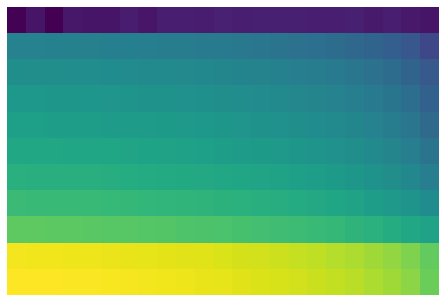

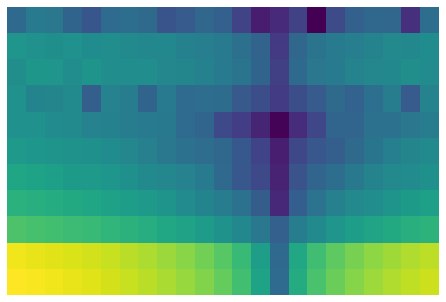

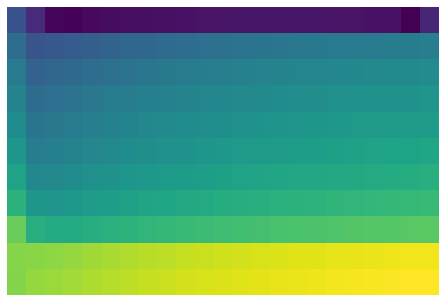

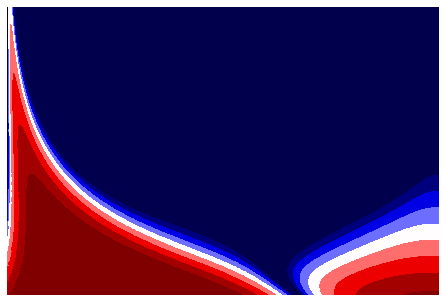

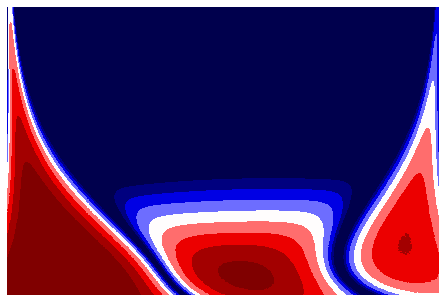

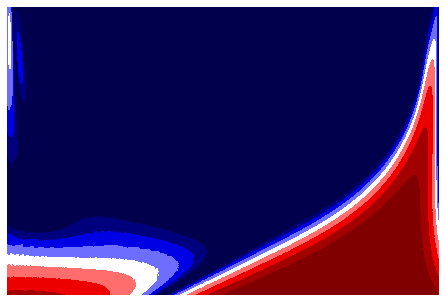

In [49]:
import warnings
warnings.filterwarnings('ignore')

exp = 'rot'
ax_val = 'all'
ss_val = 'all'
df_test2 = run_main_script(exp, ax_val, ss_val)

In [ ]:
# ------------------------------
# Manual runs
# Justification for not doing a loop : Can not do a loop because the computer stops or it stops 
# for weird reasons.  Have to run each manually.
# ------------------------------


# -------------
# DONE
# -------------

exp = 'rot'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'all'
ss_val = 'sub'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'all'
ss_val = 'sup'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'trans'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'all'
ss_val = 'sub'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'all'
ss_val = 'sup'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'rot'
ax_val = 'ax0'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'ax1'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'ax2'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'trans'
ax_val = 'ax0'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'ax1'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'ax2'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)


# Load saved data to see if it is correct

In [39]:
path = '/home/oem2/Documents/9_Motor_classification_2018-22/Coding_version3_python_FINAL/e_classification/Resultats_j02m06a22/'
file = 'res_exp_rot_all_all_ynum0_RF.pkl'
file_name = path+file
out = load_dat_pickle(file_name=file_name)
dff = pd.DataFrame(out)
dff.columns= ['ynum', 'm_name', 'fea', 'X_cols', 'acc_train', 'prec_train', 'recall_train', 'roc_auc_train', 'acc_test', 'prec_test', 'recall_test', 'roc_auc_test', 'marquers_important', 'extra']
dff


,ynum,m_name,fea,X_cols,acc_train,prec_train,recall_train,roc_auc_train,acc_test,prec_test,recall_test,roc_auc_test,marquers_important,extra
0,0,RF,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.949061,0.949061,0.949061,0.484441,0.593448,0.593448,0.593448,0.364488,"{4: 0.03658073270013566, 11: 0.029587129288621...",NaN
1,0,RF,1,"[4, 11, 1]",0.779259,0.779259,0.779259,0.464139,0.509459,0.509459,0.509459,0.422953,"{4: 0.03658073270013566, 11: 0.029587129288621...",NaN
2,0,RF,2,"[4, 11]",0.751820,0.751820,0.751820,0.456548,0.498255,0.498255,0.498255,0.358083,"{4: 0.03658073270013566, 11: 0.029587129288621...",NaN
3,0,RF,3,[4],0.652042,0.652042,0.652042,0.376620,0.489979,0.489979,0.489979,0.286871,"{4: 0.03658073270013566, 11: 0.029587129288621...",NaN


In [40]:
path = '/home/oem2/Documents/9_Motor_classification_2018-22/Coding_version3_python_FINAL/e_classification/'
file = 'res_exp_rot_all_all_ynum0_RF.pkl'
file_name = path+file
out = load_dat_pickle(file_name=file_name)
dff = pd.DataFrame(out)
dff.columns= ['ynum', 'm_name', 'fea', 'X_cols', 'acc_train', 'prec_train', 'recall_train', 'roc_auc_train', 'acc_test', 'prec_test', 'recall_test', 'roc_auc_test', 'marquers_important', 'extra']
dff


,ynum,m_name,fea,X_cols,acc_train,prec_train,recall_train,roc_auc_train,acc_test,prec_test,recall_test,roc_auc_test,marquers_important,extra
0,0,RF,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.960446,0.960446,0.960446,0.531786,0.879060,0.879060,0.879060,0.594286,"{18: 0.04001711558823954, 23: 0.03196988816848...",NaN
1,0,RF,1,"[18, 23, 1]",0.827166,0.827166,0.827166,0.491233,0.746399,0.746399,0.746399,0.499515,"{18: 0.04001711558823954, 23: 0.03196988816848...",NaN
2,0,RF,2,"[18, 23]",0.768268,0.768268,0.768268,0.482862,0.682491,0.682491,0.682491,0.488780,"{18: 0.04001711558823954, 23: 0.03196988816848...",NaN
3,0,RF,3,[18],0.717733,0.717733,0.717733,0.468451,0.654918,0.654918,0.654918,0.478537,"{18: 0.04001711558823954, 23: 0.03196988816848...",NaN


# Individual tests

In [ ]:
fea = 0

# Order of which features to use in a model
if fea == 0:
    # 1) All features
    X_cols = list(np.arange(1, df_test2.shape[1]-1, 1))
    y_cols = [df_test2.shape[1]-1]
elif fea == 1:
    # 2) first 3 from permutation_importance
    X_cols = [list(marquers_important.items())[oo][0] for oo in range(3)]
    y_cols = [df_test2.shape[1]-1]
elif fea == 2:
    # 3) first 2 from permutation_importance
    X_cols = [list(marquers_important.items())[oo][0] for oo in range(2)]
    y_cols = [df_test2.shape[1]-1]
elif fea == 3:
    # 4) first feature from permutation_importance
    X_cols = [list(marquers_important.items())[0][0]]
    y_cols = [df_test2.shape[1]-1] 


# Spatial (find global trends in the feature) : CNN
m_name = 'CNN'
#dict_out, X_test, Y_test, desired_col = run_CNN(df, ynum)

In [ ]:
# dict_out, X_test, Y_test, desired_col = run_CNN(df, ynum)

# ----------------
img_dim = 64

# Folding data into CNN image format:
X_train_img, X_test_img, Y_train_1D, Y_test_1D, info  = initialize_CNN(df_test2, X_cols, y_cols, img_dim)
batch = info['batch_train']
timesteps_train = info['timesteps_train'] 
feature = info['feature_train']
n_outputs = info['n_outputs']

In [ ]:

# ----------------

# Model architecture
epochs = 80
batch_size = 32

tot = []
tot_mod = []
mod_type = ['mpcnn', 'dcgan', 'encdec'] # CNN model architecture type

for i in range(3):
    if i == 0:
        model = MPCNN_arch(n_outputs, img_dim, X_train_img.shape[3], ynum)
    elif i == 1:
        model = dcgan_arch(n_outputs, img_dim, ynum)
    elif i == 2:
        model = encoderdecoder_arch(n_outputs, img_dim, X_train_img.shape[3], ynum)

    patience = 5 # Number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

    # -------------------------------

    if i == 1:
        # Transformez 3D image à 2D matrix
        X_train_1D = []
        for lay in range(X_train_img.shape[0]):
            X_train_2D = imgORmat_resize_imgORmat_CNN(img_dim, X_train_img[lay,:,:,:], inpt='img3D', outpt='mat2D', norm='non', thresh='non')
            X_train_1D.append(X_train_2D.flatten())
        
        X_test_1D = []
        for lay in range(X_test_img.shape[0]):
            X_test_2D = imgORmat_resize_imgORmat_CNN(img_dim, X_test_img[lay,:,:,:], inpt='img3D', outpt='mat2D', norm='non', thresh='non')
            X_test_1D.append(X_test_2D.flatten())
        
        X_train_1D = np.array(X_train_1D)
        X_test_1D = np.array(X_test_1D)
        print('X_train_1D : ', X_train_1D.shape)
        print('X_test_1D : ', X_test_1D.shape)

        history = model.fit(X_train_1D, Y_train_1D, epochs=epochs, validation_data=(X_test_1D, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=0)
    else:
        history = model.fit(X_train_img, Y_train_1D, epochs=epochs, validation_data=(X_test_img, Y_test_1D), batch_size=batch_size, callbacks=[early_stopping], verbose=0)


    history_df = pd.DataFrame(history.history)
    out = [history_df.iloc[:,i].mean() for i in range(len(history_df.columns))]

    tot.append(out)
    tot_mod.append(model)

tot = np.array(tot)

# -------------------------------

a = np.argmax(tot[:,1])  # train
b = np.argmax(tot[:,6])  # test
suf = ['train', 'test']
tr_noms = ['loss_', 'acc_', 'prec_', 'recall_', 'roc_auc_']

list2 = [j+i for i in suf for j in tr_noms]
list2

dict_out = {}
for i in range(len(list2)):
    if i < len(list2)/2:
        r = tot[a,i]
    else:
        r = tot[b,i]
    dict_out[list2[i]] = r


# ajoutez au dictionaire
dict_out['mod_train'] = mod_type[a]
dict_out['mod_test'] = mod_type[b]

# -------------------------------

cnn2D_model_best = tot_mod[b]

In [ ]:
dict_out

# Checking kmeans 

In [103]:
df = get_df(ax_val, ss_val)

feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0 = create_labels_and_initial_feature(df) 
# Elasped time for feature processing :  715.9615476131439

del df

Confirmation : exp= rot , ax_val= all , ss_val= all


num de samples avant dropna :  142
num de samples apres dropna :  142


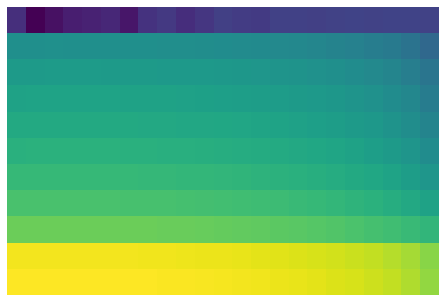

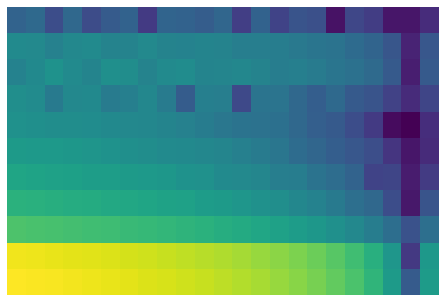

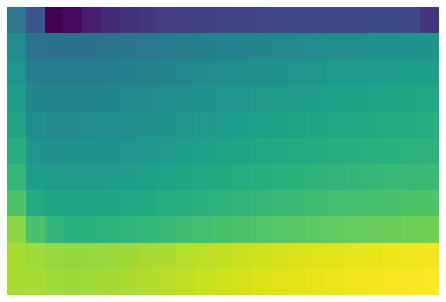

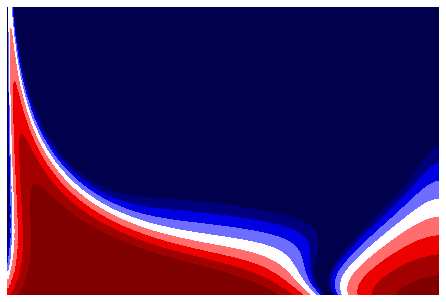

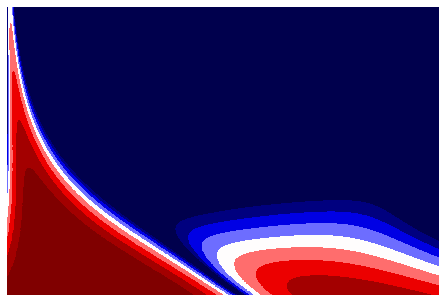

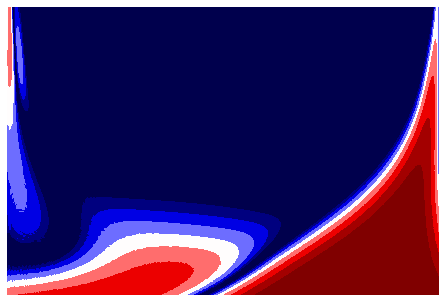

In [129]:
start = time.time()

# ----------------
# Make your features
# ----------------
df_feat = pd.DataFrame()

n = 4   # filter order
fs = 250 # data sampling frequency (Hz)
fcc = 10  # Cut-off frequency of the filter
w = fcc / (fs / 2) # Normalize the frequency
b, a = signal.butter(n, w, 'low')  # 3rd order

scales = np.arange(1, 128)

print('num de samples avant dropna : ', len(feat0))

# ----------------

# Drop nan values from feat0
temp = pd.DataFrame(feat0)
temp0 = my_dropna_python(temp)
feat0 = temp0.to_numpy()
print('num de samples apres dropna : ', len(feat0))

# ----------------

# Drop all zero samples from feat0
temp = []
for i in range(len(feat0)):
    if int(np.mean(feat0[i])) != 0:
        temp.append(feat0[i])
del feat0
feat0 = temp
del temp

# ----------------


# Need to find when one trial starts and end - take derivative from start-stop periods
for i in range(0,1):   # range(len(feat0)):
    
    if i == 0:
        plotORnot = 0 #1
    else:
        plotORnot = 0

    # ----------------------------
    # (0) position - causale ordre
    col0 = scale_feature_data(feat0[i], plotORnot)
    # col0 = np.reshape(col0, (len(col0),1))
    col0 = np.ravel(col0)
    # print('col0 : ', col0.shape)   # col0 :  (471,)
    
    # (1) velocity - causale ordre
    vel = numderiv(feat0[i], t_feat0[i])
    col1 = scale_feature_data(vel, plotORnot)
    # col1 = np.reshape(col1, (len(col1),1))
    col1 = np.ravel(col1)
    # print('col1 : ', col1.shape)   # col1 :  (471,)

    # (2) acceleration - causale ordre
    acc = numderiv(vel, t_feat0[i])
    filtacc = signal.filtfilt(b, a, acc) # the signal is noisy
    col2 = scale_feature_data(filtacc, plotORnot)
    # col2 = np.reshape(col2, (len(col2),1))
    col2 = np.ravel(col2)
    # print('col2 : ', col2.shape)   # col2 :  (471,)
    # ----------------------------

    # ----------------------------
    # (4) position - non-causale ordre
    col3 = normal_distribution_feature_data(col0, plotORnot)
    col3 = np.ravel(col3)
    # print('col3 : ', col3.shape)   # col3 :  (471,)
    
    # (5) velocity - non-causale ordre
    col4 = normal_distribution_feature_data(col1, plotORnot)
    col4 = np.ravel(col4)
    # print('col4 : ', col4.shape)   # col4 :  (471,)

    # (6) acceleration - non-causale ordre
    col5 = normal_distribution_feature_data(col2, plotORnot)
    col5 = np.ravel(col5)
    # print('col5 : ', col5.shape)   # col5 :  (471,)
    # ----------------------------


    # ----------------------------
    # Frequence marquers : sublevels of frequency pattern
    # ----------------------------
    # (7-22) une transformation de fréquence (ondelettes)
    coeff = tsig_2_discrete_wavelet_transform(col0, waveletname='sym5', level=5, plotORnot=0)
    cols6 = pd.DataFrame(coeff).T
    # out6 = cols6.to_numpy()
    # print('col6 : ', out6.shape)   # col6 :  (471, 5)

    coeff = tsig_2_discrete_wavelet_transform(col1, waveletname='sym5', level=5, plotORnot=0)
    cols7 = pd.DataFrame(coeff).T
    # out7 = cols7.to_numpy()
    # print('col7 : ', out7.shape)   # col7 :  (471, 5)

    coeff = tsig_2_discrete_wavelet_transform(col2, waveletname='sym5', level=5, plotORnot=0)
    cols8 = pd.DataFrame(coeff).T
    # out8 = cols8.to_numpy()
    # print('col8 : ', out8.shape)   # col8 :  (471, 5)
    # ----------------------------


    # ----------------------------
    # Hybrid marquers : temporalle et frequence information
    # ----------------------------
    # (8) spectrogram flatten - periodogram (fft)
    col9 = tsig_2_spectrogram(col0, fs=10, nfft=20, noverlap=0, plotORnot=0)
    col9 = np.ravel(col9)
    # print('col9 : ', col9.shape)   # col9 :  (471,)
    
    col10 = tsig_2_spectrogram(col1, fs=10, nfft=20, noverlap=0, plotORnot=0)
    col10 = np.ravel(col10)
    # print('col10 : ', col10.shape)   # col10 :  (471,)

    col11 = tsig_2_spectrogram(col2, fs=10, nfft=20, noverlap=0, plotORnot=0)
    col11 = np.ravel(col11)
    # print('col11 : ', col11.shape)   # col11 :  (471,)
    # ----------------------------

    # ----------------------------
    # (9) continuous wavelet transform flatten
    # continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
    col12 = tsig_2_continuous_wavelet_transform(t_feat0[i], col0, scales, waveletname='mexh', plotORnot=0)
    col12 = np.ravel(col12)
    # print('col12 : ', col12.shape)   # col12 :  (471,)
    
    col13 = tsig_2_continuous_wavelet_transform(t_feat0[i], col1, scales, waveletname='mexh', plotORnot=0)
    col13 = np.ravel(col13)
    # print('col13 : ', col13.shape)   # col13 :  (471,)
    
    col14 = tsig_2_continuous_wavelet_transform(t_feat0[i], col2, scales, waveletname='mexh', plotORnot=0)
    col14 = np.ravel(col14)
    # print('col14 : ', col14.shape)   # col14 :  (471,)
    # ----------------------------

    # ----------------------------
    # (10) kmeans
    n_clusters = 2
    col1 = np.reshape(col1, (len(col1),1))
    col2 = np.reshape(col2, (len(col2),1))
    col3 = np.reshape(col3, (len(col3),1))
    X = [col1, col2, col3]
    X = np.reshape(X, (len(col3),3))

    kmeans, col15, centroids = unsupervised_lab_kmeans_clustering(n_clusters, X)
    col15 = np.ravel(col15)
    # print('col15 : ', col15.shape)   # col15 :  (471,)
    # ----------------------------


    # Peut-être faire des non-causale frequence marquers pour des mieux frequence et hybrid 
    num = i*np.ones((len(col0)))
    # print('num : ', num.shape)   # num :  (471,)
    
    

In [130]:
part1 = pd.DataFrame(data=[num, col0, col1, col2, col3, col4, col5]).T
part1

,0,1,2,3,4,5,6
0,0.0,0.963067,[1.0],[0.9158526546062169],[0.5552503935714771],5.199338,1.523396
1,0.0,0.964126,[0.9999999999999996],[0.7852746122063349],[0.5677381747778057],5.199338,1.022841
2,0.0,0.965185,[0.9953944783501263],[0.6572502324740424],[0.5803151278188501],2.63111,0.718676
3,0.0,0.966223,[0.9921906372023845],[0.535278865093417],[0.5929845539816321],2.490232,0.47008
4,0.0,0.967245,[0.9907836271165676],[0.4224118488966214],[0.6057498875430153],2.386248,0.247844
...,...,...,...,...,...,...,...
466,0.0,0.014591,[0.009917792174889395],[0.9481356355870856],[-2.386247821611854],-1.013884,1.770789
467,0.0,0.010939,[0.010474865020284854],[0.934093388420632],[-2.4902324422289266],-0.996208,1.676619
468,0.0,0.00729,[0.01127700546763938],[0.9192809250751307],[-2.631110406252946],-0.970264,1.558356
469,0.0,0.003645,[0.011277005467759942],[0.9041539838632655],[-2.858587364286917],-0.957534,1.443299


In [101]:
df_org = df_feat

del df_feat
# ----------------

col_list = ['num', 'pos', 'vel', 'acc', 'pos_nc', 'vel_nc', 'acc_nc', 'pos_sl0', 'pos_sl1', 'pos_sl2', 
            'pos_sl3', 'pos_sl4', 'vel_sl0', 'vel_sl1', 'vel_sl2', 'vel_sl3', 'vel_sl4', 'acc_sl0', 
            'acc_sl1', 'acc_sl2', 'acc_sl3', 'acc_sl4', 'pos_spec', 'vel_spec', 'acc_spec', 'pos_cwt', 
            'vel_cwt', 'acc_cwt', 'kmeans']
df_org = pandas_rename_columns(df_org, col_list)
df_org = df_org.reset_index(drop=True)  # reset index : delete the old index column
# Gardez df_org

# ----------------

y_alllabel = [y1_feat0, y2_feat0, y3_feat0]

# ----------------

# Loop over the different y labels
for ynum in range(1):    #range(len(y_alllabel)):
    print('ynum : ', ynum)

    # ----------------

    # Select y
    y_label = y_alllabel[ynum]

    # ----------------

    # Ajoutez le column de label à la fin
    y_pd = pd.Series(make_a_properlist(y_label))

    # ----------------

    df_feat = pd.concat([df_org, y_pd], axis=1)
    df_feat = df_feat.rename({0: 'y'}, axis=1)

    # ----------------

    # Balancez des class/labels: pad
    # Pad data 2 Make Classes Equivalent
    df_test2 = pad_data_2makeclasses_equivalent(df_feat)

ValueError: Length mismatch: Expected axis has 957 elements, new values have 29 elements

# EXTRA

In [ ]:
# Hyperparametre tuning : NuSVC
acc_test = 0.6136727078891258
acc_train = 0.929637526652452
gamma_l[8] = 0.2222222222222222

# Adaptive : NuSVC
acc_test = 0.8214285714285714
acc_train = 0.9360341151385928
5 	5.0 	0.936034 	0.936034 	0.936034 	0.447889 	0.821429 	0.821429 	0.821429 	0.310647
gamma

# Hyperparametre tuning : SVC
acc_test = 0.7193496801705757
acc_train = 0.9786780383795309
C_l[12] = 1.56
12 	12.0 	0.978678 	0.978678 	0.978678 	0.668755 	0.719350 	0.719350 	0.719350 	0.866848

# Adaptive : SVC - batch_size = 16
acc_test = 0.7214818763326226  (test = batch)
acc_test = 0.5898623764295406  (test = all data)
acc_train = 0.9898720682302772
C =  1.18

12 	12.0 	1.18 	0.968950 	0.968950 	0.968950 	0.666856 	0.589862 	0.589862 	0.589862 	0.886586

# Adaptive : SVC - batch_size = 24
acc_test = 0.7214818763326226  (test = batch)
acc_test = 0.5768753634425277  (test = all data)
acc_train = 0.9349680170575693
C =  1.18